# Install Required Libraries

In [ ]:
# Install Required Libraries

# Core dependencies
!pip install -U google-generativeai
!pip install beautifulsoup4 requests pandas scikit-learn nltk tqdm matplotlib transformers accelerate safetensors
!python -m spacy download en_core_web_sm


# Import Libraries

# For Google Generative AI
import os
import google.generativeai as genai
from google.colab import userdata  # Only needed in Colab environments

# Web scraping
import requests
from bs4 import BeautifulSoup

# Data handling and processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns in full
pd.set_option('display.max_columns', None)  # Show all columns

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import ast
import json

# NLP models and vectorization
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer

# Feature engineering and modeling
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import hstack
from tqdm import tqdm

# Display tools
from IPython.display import display
import random


# Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from collections import Counter
import logging
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

# Web Performance Data

In [ ]:
#  web performance data from May 12, 2025
performance = pd.read_excel("uk_pages_performance_may2025.xlsx")
performance.head()

,URL,views_anon,clicks_anon,avg_time_on_page_anon
0,https://www.bsigroup.com/en-GB/training-course...,0.0004,0.0001,0.1023
1,https://www.bsigroup.com/en-GB/training-course...,0.0002,0.0000,0.0439
2,https://www.bsigroup.com/en-GB/training-course...,0.0009,0.0005,0.0680
3,https://www.bsigroup.com/en-GB/training-course...,0.0005,0.0000,0.0647
4,https://www.bsigroup.com/en-GB/training-course...,0.0003,0.0000,0.0714


In [ ]:
performance.shape

(2154, 4)

In [ ]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URL                    2154 non-null   object 
 1   views_anon             2154 non-null   float64
 2   clicks_anon            2154 non-null   float64
 3   avg_time_on_page_anon  2154 non-null   float64
dtypes: float64(3), object(1)
memory usage: 67.4+ KB


# Web Crawling

In [ ]:
# Step 1: Get sitemap from robots.txt
robots_url = "https://www.bsigroup.com/robots.txt"
r = requests.get(robots_url)
lines = r.text.split("\n")
sitemap_url = None

# extract the correct sitemap URL
for line in lines:
    if line.lower().startswith("sitemap:"):
        sitemap_url = line.split(": ", 1)[-1].strip()
        break

print("Sitemap found:", sitemap_url)

Sitemap found: https://www.bsigroup.com/sitemap/index.xml


In [ ]:
# Step 2: Get en-GB sitemap from index.xml
sitemap_response = requests.get(sitemap_url)
soup = BeautifulSoup(sitemap_response.content, "xml")

# Get en-GB sitemap
en_gb_sitemap_link = None
for loc in soup.find_all("loc"):
    if "sitemap-en-GB.xml" in loc.text:
        en_gb_sitemap_link = loc.text
        break

print("English sitemap link:", en_gb_sitemap_link)

English sitemap link: https://www.bsigroup.com/sitemap/sitemap-en-GB.xml


In [ ]:
# Step 3: Load the en-GB sitemap and extract all real page URLs
en_gb_response = requests.get(en_gb_sitemap_link)
en_gb_soup = BeautifulSoup(en_gb_response.content, "xml")

all_urls = [loc.text for loc in en_gb_soup.find_all("loc")]

print(f"Found {len(all_urls)} en-GB page URLs.")
all_urls[:5]

Found 2228 en-GB page URLs.


['https://www.bsigroup.com/en-GB/',
 'https://www.bsigroup.com/en-GB/our-expertise/health-safety-and-well-being/',
 'https://www.bsigroup.com/en-GB/our-expertise/sustainability/',
 'https://www.bsigroup.com/en-GB/our-expertise/supply-chain/',
 'https://www.bsigroup.com/en-GB/our-expertise/digital-trust/']

In [ ]:
# Step 4: Full Page Content Extraction

# Define a function to extract content and meta features from a webpage
def extract_content_features(soup):
    # Extract <h1> title
    title_tag = soup.find("h1")
    title_text = title_tag.get_text(strip=True) if title_tag else ""

    # Define meta tags to extract
    meta_tags = {
        "keywords": "",
        "description": "",
        "CountrySite": "",
        "Locale": "",
        "MachineName": "",
        "industries-tag": "",
        "search-tag": "",
        "standards-tag": "",
        "themes-tag": "",
        "capabilities-tag": "",
        "Insights-media-tag": "",
        "products-services-tag": "",
        "Template": "",
        "PageId": ""
    }

    # Extract meta tag content
    for tag in soup.find_all("meta"):
        if "name" in tag.attrs:
            name = tag.attrs["name"]
            if name in meta_tags:
                meta_tags[name] = tag.get("content", "").strip()

    # Extract body text
    body_text = ""
    for tag in soup.find_all(["p", "li", "div", "span", "blockquote"]):
        if tag.get("class") and any("search" in c for c in tag.get("class")):
            continue
        txt = tag.get_text(strip=True)
        if txt and txt not in body_text:
            body_text += " " + txt

    return title_text, body_text.strip(), meta_tags

In [ ]:
# Step 5: Crawl each page and extract all desired features
results = []

for url in tqdm(all_urls, desc="Crawling pages"):
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.content, "html.parser")

        title, text, meta = extract_content_features(soup)

        # Base structure
        data = {
            "url": url,
            "title": title,
            "text": text
        }

        # Merge meta features
        data.update(meta)

        results.append(data)

        # Respectful delay to avoid getting blocked
        time.sleep(0.05)

    except Exception:
        # Just silently skip the failed URL without printing
        continue

Crawling pages: 100%|██████████| 2228/2228 [37:02<00:00,  1.00it/s]


In [ ]:
# Step 6: Convert to DataFrame and export
web = pd.DataFrame(results)
web.head()

,url,title,text,keywords,description,CountrySite,Locale,MachineName,industries-tag,search-tag,standards-tag,themes-tag,capabilities-tag,Insights-media-tag,products-services-tag,Template,PageId
0,https://www.bsigroup.com/en-GB/,Accelerating progress towards a sustainable world,"Popular searches Suggestions Sorry, we couldn'...","ISO 9001, training, certification, standards, ...","Discover BSI Group United Kingdom, the global ...",Group,en-GB,BSI16WEB07PUB,Multiple industries,Home page,Other,Other,Other,Other,Other,V1HomePage,904603
1,https://www.bsigroup.com/en-GB/our-expertise/h...,"Health, Safety & Well-being","Popular searches Suggestions Sorry, we couldn'...","ergonomics, health and safety, office health a...","Explore BSI's health, safety, and well-being s...",Group,en-GB,BSI16WEB08PUB,Healthcare,Expertise,Other,"Health & Safety, Health, Safety & Well-being",,Other,Other,V1ExpertisePage,906781
2,https://www.bsigroup.com/en-GB/our-expertise/s...,Sustainability,"Popular searches Suggestions Sorry, we couldn'...","sustainability policies, esg, sustainability a...","Explore BSI's sustainability services, support...",Group,en-GB,BSI16WEB08PUB,Multiple industries,Expertise,Other,"Environment, Sustainability",,Other,Other,V1ExpertisePage,906806
3,https://www.bsigroup.com/en-GB/our-expertise/s...,Supply Chain,"Popular searches Suggestions Sorry, we couldn'...","supply chain, security, resilience","Explore BSI's supply chain services, promoting...",Group,en-GB,BSI16WEB08PUB,Multiple industries,Expertise,Other,"Digital Supply Chain, Digital Trust, Prioritiz...",,Other,Other,V1ExpertisePage,906807
4,https://www.bsigroup.com/en-GB/our-expertise/d...,Digital Trust,"Popular searches Suggestions Sorry, we couldn'...",Digital trust,"Discover BSI's expertise in digital trust, foc...",Group,en-GB,BSI16WEB08PUB,Multiple industries,Expertise,Other,"Artificial Intelligence, Cybersecurity, Data &...",,Other,Other,V1ExpertisePage,906856


In [ ]:
# Save web df
web.to_csv("web.csv", index=False)

In [ ]:
# web = pd.read_csv("web.csv", na_values=["NaN", "nan", ""])

In [ ]:
web.shape

(2228, 17)

In [ ]:
web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   url                    2228 non-null   object
 1   title                  2228 non-null   object
 2   text                   2228 non-null   object
 3   keywords               2228 non-null   object
 4   description            2228 non-null   object
 5   CountrySite            2228 non-null   object
 6   Locale                 2228 non-null   object
 7   MachineName            2228 non-null   object
 8   industries-tag         2228 non-null   object
 9   search-tag             2228 non-null   object
 10  standards-tag          2228 non-null   object
 11  themes-tag             2228 non-null   object
 12  capabilities-tag       2228 non-null   object
 13  Insights-media-tag     2228 non-null   object
 14  products-services-tag  2228 non-null   object
 15  Template             

In [ ]:
# Step 7: Merge the two dataframes
df = performance.merge(web, left_on='URL', right_on='url', how='left')

# Drop the duplicate 'url' column
df.drop(columns=['url'], inplace=True)

# Display the first few rows
df.head()

,URL,views_anon,clicks_anon,avg_time_on_page_anon,title,text,keywords,description,CountrySite,Locale,MachineName,industries-tag,search-tag,standards-tag,themes-tag,capabilities-tag,Insights-media-tag,products-services-tag,Template,PageId
0,https://www.bsigroup.com/en-GB/training-course...,0.0004,0.0001,0.1023,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Understanding FSSC 22000 v6 Training Course,Understanding FSSC 22000 v6 Training Course,Group,en-GB,BSI16WEB07PUB,"Food Safety, Multiple industries",Training & Qualifications,ISO 22000,"Health, Safety & Well-being",,Other,Other,V1CoursePage,922212
1,https://www.bsigroup.com/en-GB/training-course...,0.0002,0.0000,0.0439,Understanding Bribery and Effective Due Dilige...,"Popular searches Suggestions Sorry, we couldn'...",Understanding Bribery and Effective Due Diligence,"A training course that introduces the nature, ...",Group,en-GB,BSI16WEB08PUB,Multiple industries,Training & Qualifications,Other,Other,Other,Other,Training & Qualifications,V1CoursePage,922032
2,https://www.bsigroup.com/en-GB/training-course...,0.0009,0.0005,0.0680,Understanding and Implementing an AI System Im...,"Popular searches Suggestions Sorry, we couldn'...",This course will provide you with the understa...,This course will provide you with the understa...,Group,en-GB,BSI16WEB08PUB,"ICT, Multiple industries",Training & Qualifications,"ISO 42001, Other",Artificial Intelligence,Other,Other,Training & Qualifications,V1CoursePage,948603
3,https://www.bsigroup.com/en-GB/training-course...,0.0005,0.0000,0.0647,Understanding and Implementing AI System Impac...,"Popular searches Suggestions Sorry, we couldn'...","Obtain an understanding of the key terms, defi...","Obtain an understanding of the key terms, defi...",Group,en-GB,BSI16WEB08PUB,"ICT, Multiple industries",Training & Qualifications,"ISO 42001, Other",Artificial Intelligence,,Other,Training & Qualifications,V1CoursePage,960513
4,https://www.bsigroup.com/en-GB/training-course...,0.0003,0.0000,0.0714,Underpinning Knowledge for Workplace Transport...,"Popular searches Suggestions Sorry, we couldn'...","iso 39001, iso 45001 workplace transport risks...",The aim of this course is to provide underpinn...,Group,en-GB,BSI16WEB07PUB,Multiple industries,Training & Qualifications,"ISO 39000, Other","Health & Safety, Health, Safety & Well-being",,Other,Training & Qualifications,V1CoursePage,922330


In [ ]:
df.shape

(2154, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URL                    2154 non-null   object 
 1   views_anon             2154 non-null   float64
 2   clicks_anon            2154 non-null   float64
 3   avg_time_on_page_anon  2154 non-null   float64
 4   title                  2125 non-null   object 
 5   text                   2125 non-null   object 
 6   keywords               2125 non-null   object 
 7   description            2125 non-null   object 
 8   CountrySite            2125 non-null   object 
 9   Locale                 2125 non-null   object 
 10  MachineName            2125 non-null   object 
 11  industries-tag         2125 non-null   object 
 12  search-tag             2125 non-null   object 
 13  standards-tag          2125 non-null   object 
 14  themes-tag             2125 non-null   object 
 15  capa

In [ ]:
# Define the critical columns
critical_cols = [
    "URL", "views_anon", "clicks_anon", "avg_time_on_page_anon",
    "title", "text", "keywords", "description"
]

# Step 1: Replace "NaN", "nan", "" with actual NaN ONLY in those columns
df[critical_cols] = df[critical_cols].replace(["NaN", "nan", ""], np.nan)

# Step 2: Drop rows where any of those critical columns are missing
df_filtered = df.dropna(subset=critical_cols)

# Step 3: Check the result
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2118 entries, 0 to 2153
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URL                    2118 non-null   object 
 1   views_anon             2118 non-null   float64
 2   clicks_anon            2118 non-null   float64
 3   avg_time_on_page_anon  2118 non-null   float64
 4   title                  2118 non-null   object 
 5   text                   2118 non-null   object 
 6   keywords               2118 non-null   object 
 7   description            2118 non-null   object 
 8   CountrySite            2118 non-null   object 
 9   Locale                 2118 non-null   object 
 10  MachineName            2118 non-null   object 
 11  industries-tag         2118 non-null   object 
 12  search-tag             2118 non-null   object 
 13  standards-tag          2118 non-null   object 
 14  themes-tag             2118 non-null   object 
 15  capabilit

In [ ]:
# Import necessary libraries (assuming you are in a Google Colab environment)

df_filtered.to_csv('df_filtered.csv', index=False)

In [ ]:
# df_filtered = pd.read_csv("df_filtered.csv")
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2118 entries, 0 to 2153
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URL                    2118 non-null   object 
 1   views_anon             2118 non-null   float64
 2   clicks_anon            2118 non-null   float64
 3   avg_time_on_page_anon  2118 non-null   float64
 4   title                  2118 non-null   object 
 5   text                   2118 non-null   object 
 6   keywords               2118 non-null   object 
 7   description            2118 non-null   object 
 8   CountrySite            2118 non-null   object 
 9   Locale                 2118 non-null   object 
 10  MachineName            2118 non-null   object 
 11  industries-tag         2118 non-null   object 
 12  search-tag             2118 non-null   object 
 13  standards-tag          2118 non-null   object 
 14  themes-tag             2118 non-null   object 
 15  capabilit

# Lightweight EDA (Exploratory Data Analysis)

## Basic Dataset Overview

In [ ]:
df = df_filtered
# Step 1: Show basic info
print("DataFrame shape:", df.shape)

print("\nColumn types and nulls:")
print(df.info())

print("\nNull values per column:")
print(df.isnull().sum())

DataFrame shape: (2118, 20)

Column types and nulls:
<class 'pandas.core.frame.DataFrame'>
Index: 2118 entries, 0 to 2153
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URL                    2118 non-null   object 
 1   views_anon             2118 non-null   float64
 2   clicks_anon            2118 non-null   float64
 3   avg_time_on_page_anon  2118 non-null   float64
 4   title                  2118 non-null   object 
 5   text                   2118 non-null   object 
 6   keywords               2118 non-null   object 
 7   description            2118 non-null   object 
 8   CountrySite            2118 non-null   object 
 9   Locale                 2118 non-null   object 
 10  MachineName            2118 non-null   object 
 11  industries-tag         2118 non-null   object 
 12  search-tag             2118 non-null   object 
 13  standards-tag          2118 non-null   object 
 14  themes-t

In [ ]:
# Step 2: Drop rows with null values in any of the specified columns

# Drop rows contain null values
df = df.dropna()

# Optional: Reset index after dropping
df.reset_index(drop=True, inplace=True)

# Print result to confirm
print("New DataFrame shape after dropping rows with nulls:", df.shape)

New DataFrame shape after dropping rows with nulls: (2118, 20)


In [ ]:
# Step 2: Check unique values per column (to detect low-information columns)
print("\nUnique value count per column:")
print(df.nunique().sort_values())


Unique value count per column:
Locale                      1
CountrySite                 1
MachineName                 2
Insights-media-tag         11
capabilities-tag           15
products-services-tag      19
Template                   35
search-tag                 41
industries-tag             57
standards-tag              66
views_anon                174
clicks_anon               178
themes-tag                211
avg_time_on_page_anon    1024
keywords                 1795
PageId                   1822
title                    2097
description              2101
URL                      2118
text                     2118
dtype: int64


In [ ]:
# Check unique values for unique value < 10 columns
low_card_cols = ['Locale', 'CountrySite', 'MachineName', 'Insights-media-tag']

# Dictionary to store value counts for each column
low_card_value_counts = {col: df[col].value_counts(dropna=False) for col in low_card_cols}

low_card_value_counts

{'Locale': Locale
 en-GB    2118
 Name: count, dtype: int64,
 'CountrySite': CountrySite
 Group    2118
 Name: count, dtype: int64,
 'MachineName': MachineName
 BSI16WEB07PUB    1188
 BSI16WEB08PUB     930
 Name: count, dtype: int64,
 'Insights-media-tag': Insights-media-tag
 Other                                          1222
 News                                            219
 Blogs                                           164
 Brochures                                       154
 Webinars                                        104
                                                  99
 Whitepapers                                      77
 Case Studies                                     68
 Events                                            9
 Brochures, Other                                  1
 Blogs, Brochures, Case Studies, Whitepapers       1
 Name: count, dtype: int64}

## Web Performance Data

In [ ]:
# Step 3: Preview numerical distribution for web performance metrics
print("\nWeb performance metrics (basic statistics):")
print(df[['views_anon', 'clicks_anon', 'avg_time_on_page_anon']].describe())


Web performance metrics (basic statistics):
        views_anon  clicks_anon  avg_time_on_page_anon
count  2118.000000  2118.000000            2118.000000
mean      0.003405     0.004183               0.076503
std       0.029356     0.034991               0.049102
min       0.000000     0.000000               0.000000
25%       0.000100     0.000000               0.050700
50%       0.000400     0.000000               0.073100
75%       0.001200     0.000300               0.095000
max       1.000000     1.000000               1.000000


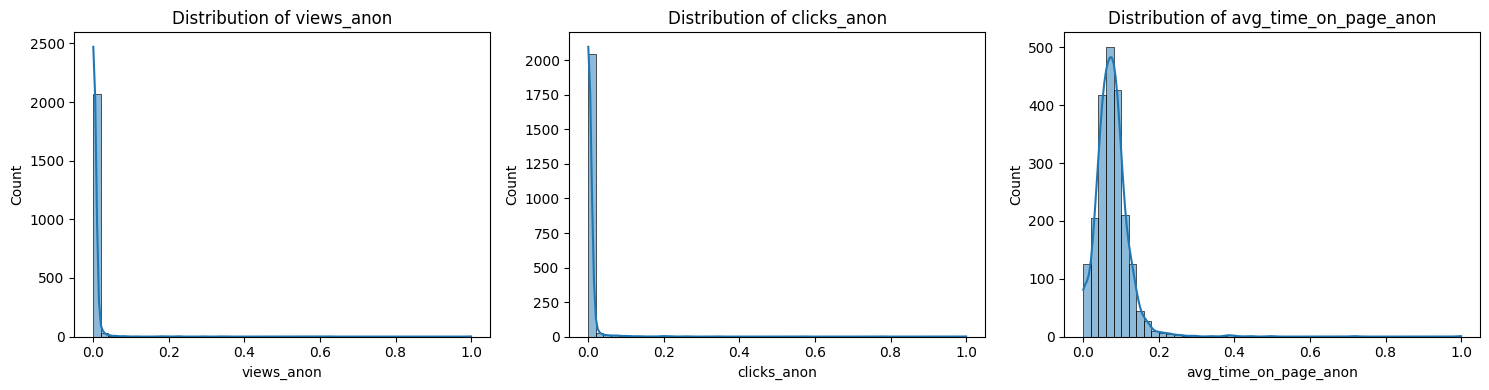

In [ ]:
# Step 4: Distribution plots for web performance metrics
plt.figure(figsize=(15, 4))

for i, col in enumerate(['views_anon', 'clicks_anon', 'avg_time_on_page_anon']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

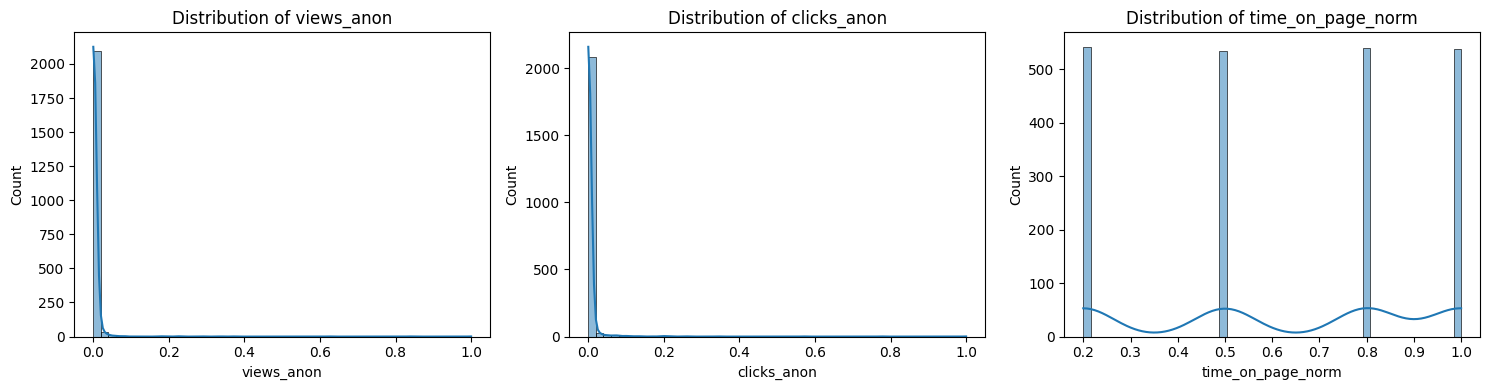

In [ ]:
# -- START OF NEW PERFORMANCE SCORE CALCULATION --

# Define the bins and corresponding scores using Quantile Binning
# We divide the data into 4 equal-sized groups (quartiles)
# and assign a clear, impactful score to each group.
bins = 4
labels = [0.2, 0.5, 0.8, 1.0] # Scores

# Use pd.qcut to create the bins. `duplicates='drop'` handles cases where quantiles are not unique.
performance['time_on_page_norm'] = pd.qcut(
    performance['avg_time_on_page_anon'],
    q=bins,
    labels=labels,
    duplicates='drop'
).astype(float)


# Distribution plots for web performance metrics
plt.figure(figsize=(15, 4))

for i, col in enumerate(['views_anon', 'clicks_anon', 'time_on_page_norm']):
    plt.subplot(1, 3, i+1)
    sns.histplot(performance[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

/tmp/ipython-input-11-1954481047.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Zero', 'Non-zero'], y=views_counts.sort_index(), palette=['#5dade2', '#3498db'])
/tmp/ipython-input-11-1954481047.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Zero', 'Non-zero'], y=clicks_counts.sort_index(), palette=['#5dade2', '#3498db'])
/tmp/ipython-input-11-1954481047.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Zero', 'Non-zero'], y=time_counts.sort_index(), palette=['#5dade2', '#3498db'])


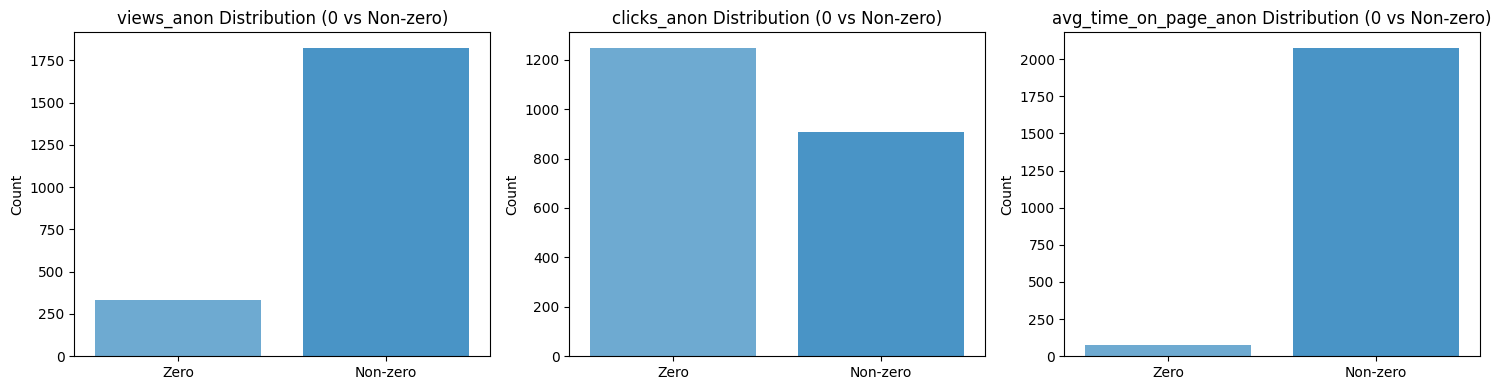

In [ ]:
# Create binary distributions (0 vs non-zero)
views_binary = (performance['views_anon'] > 0).astype(int)
clicks_binary = (performance['clicks_anon'] > 0).astype(int)
avg_time_binary = (performance['avg_time_on_page_anon'] > 0).astype(int)

# Count zeros and non-zeros
views_counts = views_binary.value_counts()
clicks_counts = clicks_binary.value_counts()
time_counts = avg_time_binary.value_counts()

# Increase figure width to avoid overlapping
plt.figure(figsize=(15, 4))

# Plot for views_anon
plt.subplot(1, 3, 1)
sns.barplot(x=['Zero', 'Non-zero'], y=views_counts.sort_index(), palette=['#5dade2', '#3498db'])
plt.title('views_anon Distribution (0 vs Non-zero)')
plt.ylabel('Count')

# Plot for clicks_anon
plt.subplot(1, 3, 2)
sns.barplot(x=['Zero', 'Non-zero'], y=clicks_counts.sort_index(), palette=['#5dade2', '#3498db'])
plt.title('clicks_anon Distribution (0 vs Non-zero)')
plt.ylabel('Count')

# Plot for avg_time_on_page_anon
plt.subplot(1, 3, 3)
sns.barplot(x=['Zero', 'Non-zero'], y=time_counts.sort_index(), palette=['#5dade2', '#3498db'])
plt.title('avg_time_on_page_anon Distribution (0 vs Non-zero)')
plt.ylabel('Count')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [ ]:
# Filter rows where views_anon = 0 and clicks_anon = 0
both_zero_df = performance[(performance['views_anon'] == 0) & (performance['clicks_anon'] == 0)]

# Calculate average of avg_time_on_page_anon for those rows
avg_time_for_zero = both_zero_df['avg_time_on_page_anon'].mean()
avg_time_for_zero

np.float64(0.058309230769230766)

## Web Crawling Data

In [ ]:
# Step 5: Define all tag-related columns for frequency inspection
tag_columns = [
    'industries-tag',
    'search-tag',
    'standards-tag',
    'themes-tag',
    'capabilities-tag',
    'Insights-media-tag',
    'products-services-tag'
]

In [ ]:
# Generate top 10 most frequent values for each tag column
tag_top_values = {col: df[col].value_counts(dropna=False).head(10) for col in tag_columns}

tag_top_values

{'industries-tag': industries-tag
 Multiple industries                            1094
 Healthcare                                      282
 ICT                                             112
 Consumer, Retail & Food, Food Safety             96
 Buildings & Construction, Built Environment      80
 Energy, Energy Management                        74
 Manufacturing                                    60
 Automotive, Transport & Mobility                 48
 Energy                                           34
 Aerospace, Transport & Mobility                  27
 Name: count, dtype: int64,
 'search-tag': search-tag
 Training & Qualifications    489
 News                         330
 Verification & Validation    300
 Blogs                        163
 Brochures                    154
 Webinars                     107
 Standards                     92
 Whitepapers                   80
 Consulting                    72
 Case Studies                  64
 Name: count, dtype: int64,
 'standards-ta

Word count in 'text' column:
count    2118.000000
mean     1735.338527
std       348.101831
min      1267.000000
25%      1525.000000
50%      1660.000000
75%      1848.000000
max      7072.000000
Name: word_count, dtype: float64


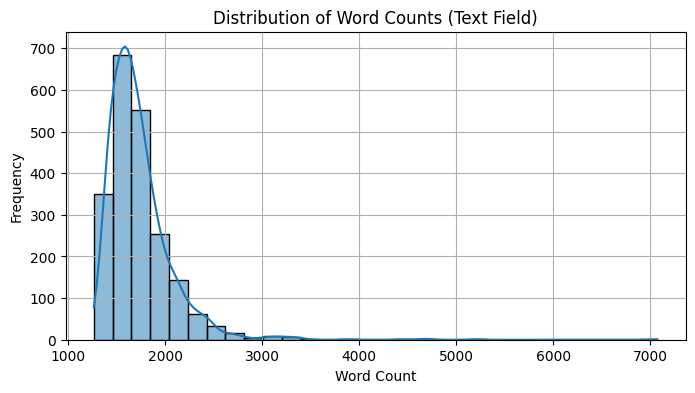

In [ ]:
# Step 6: Text length distribution

# Add word count column
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["title_len"] = df["title"].apply(lambda x: len(str(x).split()))

# Word count summary
print("Word count in 'text' column:")
print(df["word_count"].describe())

# Histogram of text length
plt.figure(figsize=(8, 4))
sns.histplot(df["word_count"], bins=30, kde=True)
plt.title("Distribution of Word Counts (Text Field)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Word count in 'title' column:
count    2118.000000
mean        7.202077
std         3.064687
min         1.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        25.000000
Name: title_len, dtype: float64


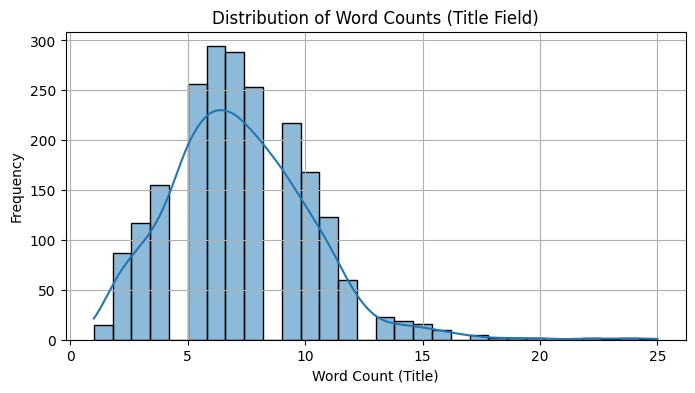

In [ ]:
# Step 7: Title length distribution

# Check title length statistics
print("Word count in 'title' column:")
print(df["title_len"].describe())

# Histogram of title lengths
plt.figure(figsize=(8, 4))
sns.histplot(df["title_len"], bins=30, kde=True)
plt.title("Distribution of Word Counts (Title Field)")
plt.xlabel("Word Count (Title)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Data Preparation

## Data Cleaning

In [ ]:
# Step 0: Create a cleaned copy of the original dataframe
df_cleaned = df.copy()

In [ ]:
# Step 1: Drop Rows with Missing Core Fields
df_cleaned = df_cleaned.dropna().reset_index(drop=True)

print(f"Rows after dropna: {df_cleaned.shape[0]}")

Rows after dropna: 2118


In [ ]:
# Step 2: Drop low-information or irrelevant columns
df_cleaned.drop(columns=['Locale', 'CountrySite', 'MachineName'], inplace=True)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2118 entries, 0 to 2117
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URL                    2118 non-null   object 
 1   views_anon             2118 non-null   float64
 2   clicks_anon            2118 non-null   float64
 3   avg_time_on_page_anon  2118 non-null   float64
 4   title                  2118 non-null   object 
 5   text                   2118 non-null   object 
 6   keywords               2118 non-null   object 
 7   description            2118 non-null   object 
 8   industries-tag         2118 non-null   object 
 9   search-tag             2118 non-null   object 
 10  standards-tag          2118 non-null   object 
 11  themes-tag             2118 non-null   object 
 12  capabilities-tag       2118 non-null   object 
 13  Insights-media-tag     2118 non-null   object 
 14  products-services-tag  2118 non-null   object 
 15  Temp

In [ ]:
df_cleaned.shape

(2118, 19)

## Website classification

In [ ]:
# Define classification function for BSI URLs
def classify_bsi_url(url):
    # Case Study pages
    if "/insights/case-studies/" in url:
        return "case_study"

    # Overview pages
    overview_keywords = [
        "/our-expertise/", "/industries/", "/insights/", "/blogs/",
        "/media-centre/", "/about-bsi/"
    ]
    if any(k in url for k in overview_keywords) or url.strip("/") == "https://www.bsigroup.com/en-GB":
        return "overview"

    # Standards / Services / Training pages
    standard_keywords = [
        "/standards/", "/training/", "/training-courses/", "/products/", "/products-and-services/",
        "/certification/", "/solutions/", "/webinars/",
        "/assessment-and-certification/", "/standards-services/"
    ]
    if any(k in url for k in standard_keywords):
        return "standards_training"

    # Other (excluded from recommendation system)
    return "other"

# Apply the classification to the DataFrame
df_cleaned["page_type"] = df_cleaned["URL"].apply(classify_bsi_url)

df_cleaned.head()

,URL,views_anon,clicks_anon,avg_time_on_page_anon,title,text,keywords,description,industries-tag,search-tag,standards-tag,themes-tag,capabilities-tag,Insights-media-tag,products-services-tag,Template,PageId,word_count,title_len,page_type
0,https://www.bsigroup.com/en-GB/training-course...,0.0004,0.0001,0.1023,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Understanding FSSC 22000 v6 Training Course,Understanding FSSC 22000 v6 Training Course,"Food Safety, Multiple industries",Training & Qualifications,ISO 22000,"Health, Safety & Well-being",,Other,Other,V1CoursePage,922212,1555,6,standards_training
1,https://www.bsigroup.com/en-GB/training-course...,0.0002,0.0000,0.0439,Understanding Bribery and Effective Due Dilige...,"Popular searches Suggestions Sorry, we couldn'...",Understanding Bribery and Effective Due Diligence,"A training course that introduces the nature, ...",Multiple industries,Training & Qualifications,Other,Other,Other,Other,Training & Qualifications,V1CoursePage,922032,1470,8,standards_training
2,https://www.bsigroup.com/en-GB/training-course...,0.0009,0.0005,0.0680,Understanding and Implementing an AI System Im...,"Popular searches Suggestions Sorry, we couldn'...",This course will provide you with the understa...,This course will provide you with the understa...,"ICT, Multiple industries",Training & Qualifications,"ISO 42001, Other",Artificial Intelligence,Other,Other,Training & Qualifications,V1CoursePage,948603,1560,8,standards_training
3,https://www.bsigroup.com/en-GB/training-course...,0.0005,0.0000,0.0647,Understanding and Implementing AI System Impac...,"Popular searches Suggestions Sorry, we couldn'...","Obtain an understanding of the key terms, defi...","Obtain an understanding of the key terms, defi...","ICT, Multiple industries",Training & Qualifications,"ISO 42001, Other",Artificial Intelligence,,Other,Training & Qualifications,V1CoursePage,960513,1617,8,standards_training
4,https://www.bsigroup.com/en-GB/training-course...,0.0003,0.0000,0.0714,Underpinning Knowledge for Workplace Transport...,"Popular searches Suggestions Sorry, we couldn'...","iso 39001, iso 45001 workplace transport risks...",The aim of this course is to provide underpinn...,Multiple industries,Training & Qualifications,"ISO 39000, Other","Health & Safety, Health, Safety & Well-being",,Other,Training & Qualifications,V1CoursePage,922330,1505,8,standards_training


## Text Cleaning

### Text Cleaning For SBERT
- only .strip()

In [ ]:
# Strip whitespace and ensure clean string format
df_cleaned['text'] = df_cleaned['text'].astype(str).str.strip()
df_cleaned['title'] = df_cleaned['title'].astype(str).str.strip()

### Text Cleaning for TF-IDF
- spaCy basic cleaning
- standard stopwords removal
- LLM-Assisted Custom Stopwords

In [ ]:
# Load English language model for spaCy
nlp = spacy.load('en_core_web_sm')

# Load stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
# Step 1: LLM- Assisted custom stopwords recognition
from google.colab import userdata

# Retrieve the secret using the correct name
secret_value = userdata.get('gemini')

In [ ]:
os.environ['GOOGLE_API_KEY'] = userdata.get("gemini")
genai.configure()

In [ ]:
# Step 1.1: Sample 50 random pages

# Combine clean title and text into a single full_text column
df_cleaned["full_text"] = df_cleaned["title"].fillna("") + " " + df_cleaned["text"].fillna("")

sample_texts = df_cleaned["full_text"].dropna().sample(n=50, random_state=42).tolist()

# Step 1.2: Create prompt
prompt_intro = (
    "You are an NLP assistant.\n\n"
    "Below are 50 samples of webpage content from a corporate standards website.\n"
    "Your task is to identify common phrases, words, or expressions that appear frequently\n"
    "across different pages but do not carry useful semantic meaning for distinguishing content.\n"
    "These phrases should be considered as custom stopwords for TF-IDF vectorization.\n\n"
    "Please return them as a clean, lowercase Python list of phrases (no duplicates)."
)

joined_text = "\n\n---\n\n".join(sample_texts)
full_prompt = prompt_intro + "\n\nHere are the text samples:\n\n" + joined_text

# Step 1.3: Run Gemini API
model = genai.GenerativeModel('models/gemini-1.5-flash')
response = model.generate_content(full_prompt)

raw_text = response.text.strip()

# Remove markdown code block headers if present
clean_text = re.sub(r"^```python\s*", "", raw_text)         # Remove starting ```python
clean_text = re.sub(r"\s*```$", "", clean_text.strip())     # Remove ending ``` (optional)

match = re.search(r"\[(.|\s)*\]", clean_text)  # greedy match including line breaks
if match:
    list_str = match.group(0)
else:
    raise ValueError("Cannot find a list inside Gemini response.")

# Step 1.4: Parse Gemini output into a Python list
try:
    # Safely convert response.text into an actual Python list
    custom_stopwords_list = ast.literal_eval(list_str)

    # Normalize: remove duplicates, strip spaces, and lowercase
    custom_stopwords_list = list(set([phrase.strip().lower() for phrase in custom_stopwords_list]))

    print("Parsed stopwords list successfully:")
    print(f"Sample: {custom_stopwords_list[:10]}")

except Exception as e:
    print("Error parsing stopwords from Gemini response:")
    print(list_str)
    raise e

ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 86775.32ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 20993.89ms


Parsed stopwords list successfully:
Sample: ['assessment & certification', 'contact us', 'skip', 'to inquire about employment or to submit a resume, visit our careers page.', 'please use this form for non-employment contacts.', 'accessibility', 'bsi kitemark', 'buy standards on bsi knowledge', 'we are committed to providing our clients with impartial and independent certification services.', 'impartiality']


In [ ]:
# Step 2: Merge Gemini-generated stopwords with spaCy stopword set
stop_words = stop_words.union(set(custom_stopwords_list))

In [ ]:
# Step 3: Define Text Cleaning Functions

# Basic text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

# Tokenization, remove stopwords, and lemmatization
def preprocess_text(text):
    text = clean_text(text)
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.text not in stop_words and token.is_alpha:
            tokens.append(token.lemma_)
    return " ".join(tokens)

In [ ]:
# Step 4: Apply Preprocessing


# Apply preprocessing
df_cleaned["text_clean"] = df_cleaned["text"].apply(preprocess_text)
df_cleaned["title_clean"] = df_cleaned["title"].apply(preprocess_text)

# Combine for later TF-IDF embedding
df_cleaned["full_text_clean"] = df_cleaned["title_clean"].fillna("") + " " + df_cleaned["text_clean"].fillna("")


# Calculate metrics after cleaning
df_cleaned["text_word_count_clean"] = df_cleaned["text_clean"].apply(lambda x: len(x.split()))
df_cleaned["title_word_count_clean"] = df_cleaned["title_clean"].apply(lambda x: len(x.split()))

In [ ]:
from google.colab import files

df_cleaned.to_csv('df_cleaned.csv', index=False)
files.download('df_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df_cleaned = pd.read_csv("df_cleaned.csv")
df_cleaned.head()

,URL,views_anon,clicks_anon,avg_time_on_page_anon,title,text,keywords,description,industries-tag,search-tag,standards-tag,themes-tag,capabilities-tag,Insights-media-tag,products-services-tag,Template,PageId,word_count,title_len,page_type,full_text,text_clean,title_clean,full_text_clean,text_word_count_clean,title_word_count_clean
0,https://www.bsigroup.com/en-GB/training-course...,0.0004,0.0001,0.1023,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Understanding FSSC 22000 v6 Training Course,Understanding FSSC 22000 v6 Training Course,"Food Safety, Multiple industries",Training & Qualifications,ISO 22000,"Health, Safety & Well-being",,Other,Other,V1CoursePage,922212,1555,6,standards_training,Understanding FSSC 22000 v6 Training Course Po...,popular search sorry could not find page resul...,understand fssc v training course,understand fssc v training course popular sear...,1051,5
1,https://www.bsigroup.com/en-GB/training-course...,0.0002,0.0000,0.0439,Understanding Bribery and Effective Due Dilige...,"Popular searches Suggestions Sorry, we couldn'...",Understanding Bribery and Effective Due Diligence,"A training course that introduces the nature, ...",Multiple industries,Training & Qualifications,Other,Other,Other,Other,Training & Qualifications,V1CoursePage,922032,1470,8,standards_training,Understanding Bribery and Effective Due Dilige...,popular search sorry could not find page resul...,understand bribery effective due diligence tra...,understand bribery effective due diligence tra...,1003,7
2,https://www.bsigroup.com/en-GB/training-course...,0.0009,0.0005,0.0680,Understanding and Implementing an AI System Im...,"Popular searches Suggestions Sorry, we couldn'...",This course will provide you with the understa...,This course will provide you with the understa...,"ICT, Multiple industries",Training & Qualifications,"ISO 42001, Other",Artificial Intelligence,Other,Other,Training & Qualifications,V1CoursePage,948603,1560,8,standards_training,Understanding and Implementing an AI System Im...,popular search sorry could not find page resul...,understand implement ai system impact assessment,understand implement ai system impact assessme...,1057,6
3,https://www.bsigroup.com/en-GB/training-course...,0.0005,0.0000,0.0647,Understanding and Implementing AI System Impac...,"Popular searches Suggestions Sorry, we couldn'...","Obtain an understanding of the key terms, defi...","Obtain an understanding of the key terms, defi...","ICT, Multiple industries",Training & Qualifications,"ISO 42001, Other",Artificial Intelligence,,Other,Training & Qualifications,V1CoursePage,960513,1617,8,standards_training,Understanding and Implementing AI System Impac...,popular search sorry could not find page resul...,understand implement ai system impact assessme...,understand implement ai system impact assessme...,1089,7
4,https://www.bsigroup.com/en-GB/training-course...,0.0003,0.0000,0.0714,Underpinning Knowledge for Workplace Transport...,"Popular searches Suggestions Sorry, we couldn'...","iso 39001, iso 45001 workplace transport risks...",The aim of this course is to provide underpinn...,Multiple industries,Training & Qualifications,"ISO 39000, Other","Health & Safety, Health, Safety & Well-being",,Other,Training & Qualifications,V1CoursePage,922330,1505,8,standards_training,Underpinning Knowledge for Workplace Transport...,popular search sorry could not find page resul...,underpin knowledge workplace transport risk iso,underpin knowledge workplace transport risk is...,1013,6


# Post-Cleaning EDA (Exploratory Data Analysis)

## Basic Cleaned Datset Overview

In [ ]:
# Step 1: Basic information about cleaned dataset
print("DataFrame shape after cleaning:", df_cleaned.shape)

print("\nColumn types and non-null counts:")
print(df_cleaned.info())

print("\nNull values per column:")
print(df_cleaned.isnull().sum())

DataFrame shape after cleaning: (2118, 26)

Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2118 entries, 0 to 2117
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   URL                     2118 non-null   object 
 1   views_anon              2118 non-null   float64
 2   clicks_anon             2118 non-null   float64
 3   avg_time_on_page_anon   2118 non-null   float64
 4   title                   2118 non-null   object 
 5   text                    2118 non-null   object 
 6   keywords                2118 non-null   object 
 7   description             2118 non-null   object 
 8   industries-tag          2118 non-null   object 
 9   search-tag              2118 non-null   object 
 10  standards-tag           2118 non-null   object 
 11  themes-tag              2118 non-null   object 
 12  capabilities-tag        2118 non-null   object 
 13  Insights-media-

## Text Data

In [ ]:
# Step 2: Cleaned Text and Title data check
print("Empty text_clean rows:", (df_cleaned["text_clean"].str.strip() == "").sum())
print("Empty title_clean rows:", (df_cleaned["title_clean"].str.strip() == "").sum())
print("Empty full_text_clean rows:", (df_cleaned["full_text_clean"].str.strip() == "").sum())

Empty text_clean rows: 0
Empty title_clean rows: 0
Empty full_text_clean rows: 0


Word count in 'text_word_count_clean' column:
count    2118.000000
mean     1173.505194
std       219.663213
min       874.000000
25%      1036.000000
50%      1123.000000
75%      1256.750000
max      3913.000000
Name: text_word_count_clean, dtype: float64


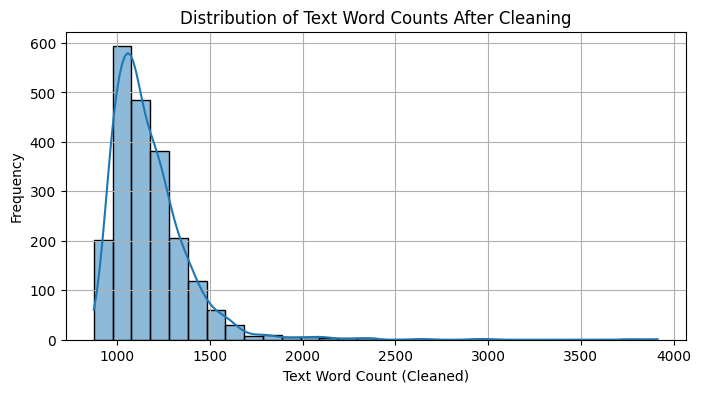

In [ ]:
# Step 3: Text length distribution

# Word count summary
print("Word count in 'text_word_count_clean' column:")
print(df_cleaned["text_word_count_clean"].describe())

# Histogram of text length
plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned["text_word_count_clean"], bins=30, kde=True)
plt.title("Distribution of Text Word Counts After Cleaning")
plt.xlabel("Text Word Count (Cleaned)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Word count in 'title_word_count_clean' column:
count    2118.000000
mean        5.535411
std         2.126918
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        17.000000
Name: title_word_count_clean, dtype: float64


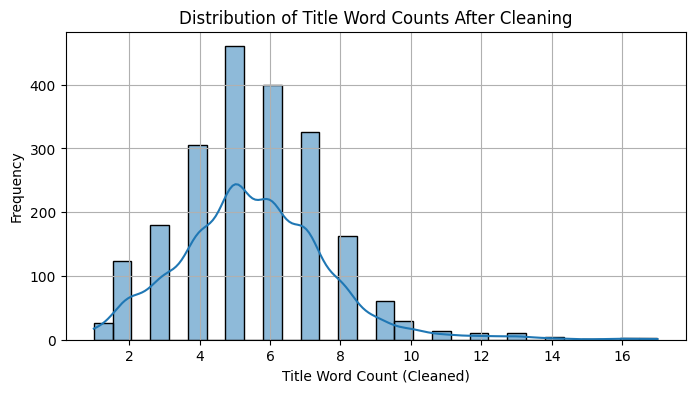

In [ ]:
# Step 4: Title length distribution

# Word count summary
print("Word count in 'title_word_count_clean' column:")
print(df_cleaned["title_word_count_clean"].describe())

# Histogram of text length
plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned["title_word_count_clean"], bins=30, kde=True)
plt.title("Distribution of Title Word Counts After Cleaning")
plt.xlabel("Title Word Count (Cleaned)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Web Performance Data

In [ ]:
df_cleaned[['views_anon', 'clicks_anon', 'avg_time_on_page_anon']].describe()

,views_anon,clicks_anon,avg_time_on_page_anon
count,2118.000000,2118.000000,2118.000000
mean,0.003405,0.004183,0.076503
std,0.029356,0.034991,0.049102
min,0.000000,0.000000,0.000000
25%,0.000100,0.000000,0.050700
50%,0.000400,0.000000,0.073100
75%,0.001200,0.000300,0.095000
max,1.000000,1.000000,1.000000


## Categorical Data

In [ ]:
# Step 5: Analyze Meta Tag Coverage per Page

# Use tag_cloumns which is defined above


# Examine each column: unique value count and percentage of "Unknown"
for col in tag_columns:
    unique_vals = df_cleaned[col].nunique()
    unknown_rate = (df_cleaned[col] == "Unknown").mean()
    print(f"{col}: {unique_vals} unique values, {unknown_rate:.2%} unknown")

industries-tag: 57 unique values, 0.00% unknown
search-tag: 41 unique values, 0.00% unknown
standards-tag: 66 unique values, 0.00% unknown
themes-tag: 211 unique values, 0.00% unknown
capabilities-tag: 15 unique values, 0.00% unknown
Insights-media-tag: 11 unique values, 0.00% unknown
products-services-tag: 19 unique values, 0.00% unknown


In [ ]:
# Step 6: Check Tag Quality for Selected Meta Tag Columns
# Step 5.1: Inspect potential data quality issues in selected tag columns

# Check how many rows in 'industries-tag' are marked as 'multiple industry'
industries_multiple = df_cleaned[df_cleaned['industries-tag'].str.lower() == 'multiple industries']
print(f"'industries-tag' with 'multiple industry': {len(industries_multiple)} rows")

# Check how many rows are marked as 'other' in the following columns
for tag_col in ['themes-tag', 'standards-tag', 'search-tag']:
    count_other = df_cleaned[df_cleaned[tag_col].str.lower() == 'other'].shape[0]
    print(f"'{tag_col}' with 'other': {count_other} rows")

'industries-tag' with 'multiple industry': 1094 rows
'themes-tag' with 'other': 645 rows
'standards-tag' with 'other': 1765 rows
'search-tag' with 'other': 0 rows


In [ ]:
# Step 7: Analyze Page Type Distribution
print("Page Type Distribution:\n")

# Create a DataFrame with counts and percentage
page_type_counts = (
    df_cleaned["page_type"]
    .value_counts()
    .rename_axis("Page Type")
    .reset_index(name="Counts")
)

# Add percentage column
total_pages = len(df_cleaned)
page_type_counts["Percentage"] = (page_type_counts["Counts"] / total_pages * 100).round(1).astype(str) + "%"

# Display the result
display(page_type_counts)

Page Type Distribution:



,Page Type,Counts,Percentage
0,standards_training,1192,56.3%
1,overview,833,39.3%
2,case_study,64,3.0%
3,other,29,1.4%


# Feature Engineering

In [ ]:
df_cleaned.shape

(2118, 26)

In [ ]:
# Select only the useful columns for feature engineering
selected_cols = [
    "URL",
    "text", "text_clean", "title", "title_clean", "full_text", "full_text_clean",
    "keywords", "description",
    "industries-tag", "standards-tag", "themes-tag", "search-tag",
    "views_anon", "clicks_anon", "avg_time_on_page_anon",
    "page_type"
]

df_fe = df_cleaned[selected_cols].copy()
target_types = ["standards_training", "overview", "case_study"]
df_fe = df_fe[df_fe["page_type"].isin(target_types)].copy()

print("Feature Engineering DataFrame shape:", df_fe.shape)

Feature Engineering DataFrame shape: (2089, 17)


## For Meta Tags

In [ ]:
# Clean tag strings and convert to sets
def parse_tag_string(tag_input):
    """
    Convert a standards-tag value (either string or list) to a cleaned set of tags.
    """
    # Handle NaN
    if tag_input is None or (isinstance(tag_input, float) and np.isnan(tag_input)):
        return set()

    # If it's already a list, clean and lower
    if isinstance(tag_input, list):
        return set(tag.strip().lower() for tag in tag_input if isinstance(tag, str) and tag.strip())

    # If it's a string, assume comma-separated or semicolon-separated
    if isinstance(tag_input, str):
        # Support both comma and semicolon separation
        split_tags = re.split(r"[;,]", tag_input)
        return set(tag.strip().lower() for tag in split_tags if tag.strip())

    # Catch-all: return empty set
    return set()

In [ ]:
# Check tag quality: include both 'other' and 'multiple industries' as invalid
tag_columns = ["standards-tag", "industries-tag", "themes-tag", "search-tag"]

for col in tag_columns:
    if col in df_fe.columns:
        df_fe[f"{col}_set"] = df_fe[col].apply(parse_tag_string)

tag_set_columns = [col for col in df_fe.columns if col.endswith("-tag_set")]

tag_quality_report = []

for col in tag_set_columns:
    total_rows = len(df_fe)

    empty_count = df_fe[col].apply(lambda x: len(x) == 0).sum()

    # Define invalid sets for 'other' or 'multiple industries'
    invalid_set = {"other", "multiple industries"}
    invalid_only_count = df_fe[col].apply(lambda x: x == invalid_set or x == {"other"} or x == {"multiple industries"}).sum()

    meaningful_count = total_rows - empty_count - invalid_only_count

    tag_quality_report.append({
        "Tag Column": col,
        "Empty (%)": round(empty_count / total_rows * 100, 2),
        "'Other/Multi-industry only' (%)": round(invalid_only_count / total_rows * 100, 2),
        "Meaningful Coverage (%)": round(meaningful_count / total_rows * 100, 2)
    })

tag_quality_df = pd.DataFrame(tag_quality_report)
display(tag_quality_df)

,Tag Column,Empty (%),'Other/Multi-industry only' (%),Meaningful Coverage (%)
0,standards-tag_set,0.05,83.10,16.85
1,industries-tag_set,0.05,51.32,48.64
2,themes-tag_set,4.74,29.92,65.34
3,search-tag_set,0.00,0.00,100.00


### Enrich industries-tag_set

In [ ]:
# Step 0: Identify valid `industries-tag` rows (not "multiple industries")
valid_mask = df_fe["industries-tag"].str.lower() != "multiple industries"
valid_mask &= df_fe["industries-tag"].str.lower() != "unknown"
valid_df = df_fe[valid_mask].copy()

print(f"Valid industries-tag rows: {len(valid_df)}")

Valid industries-tag rows: 1017


In [ ]:
# Step 1: Sample 100 valid rows for prompt construction
tagged_df = valid_df[["keywords", "description", "industries-tag"]].dropna()

# Prepare input text for the LLM
tagged_df["tag_llm_input"] = (
    tagged_df["keywords"].fillna("").astype(str).str.strip() + " " +
    tagged_df["description"].fillna("").astype(str).str.strip()
)

sample_df = tagged_df[["tag_llm_input", "industries-tag"]].sample(n=100, random_state=42)

In [ ]:
### Step 2: Build Prompt for Gemini (or other LLM)
prompt_intro = (
    "You are an industry classification assistant.\n\n"
    "Below is a set of examples from a corporate standards website.\n"
    "Each entry includes:\n"
    "- a short text from the page (keywords + description)\n"
    "- the assigned industries-tag (the content classification).\n"
    "Your task: Learn how the industries-tag is assigned from the input text.\n"
    "Then, given a new input text, predict the appropriate industries-tag.\n"
    "Return output in Python list format like this:\n"
    "'Information Technology'\n"
    "'Construction'\n"
    "Here are the examples:\n"
)

In [ ]:
example_blocks = ""
for _, row in sample_df.iterrows():
    example_blocks += f"Input: {row['tag_llm_input']}\n"
    example_blocks += f"Industries-Tag: {row['industries-tag']}\n"
    example_blocks += "-----\n"

full_prompt = prompt_intro + example_blocks

In [ ]:
# Step 3: Call Gemini 1.5 Flash
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(full_prompt)
print("LLM-Generated Tagging Rules:\n")
print(response.text)

LLM-Generated Tagging Rules:

```python
def predict_industry_tag(text):
    """Predicts the industry tag based on the input text."""

    text = text.lower()

    # Create a dictionary of keywords and their corresponding industry tags
    keyword_dict = {
        "net zero": ["Energy", "Energy Management"],
        "aerospace": ["Aerospace"],
        "biotechnology": ["Manufacturing"],
        "bsi values": ["ICT"],
        "competence programme": ["Buildings & Construction", "Built Environment"],
        "electronics manufacturers": ["Manufacturing"],
        "wearables in healthcare": ["Healthcare"],
        "occupational health and safety": ["Healthcare"],
        "bim": ["Buildings & Construction", "Multiple industries"],
        "pharmaceutical gmp": ["Healthcare"],
        "apqp": ["Automotive", "Multiple industries"],
        "cryptographic module": ["ICT"],
        "certified information privacy manager": ["ICT"],
        "healthcare workforce": ["Healthcare"],
        "clinica

In [ ]:
# Step 4: Apply LLM tagging rule to invalid industries-tag rows only

# Step 4.1: Define the LLM-generated rule-based tagging function
def predict_industry_tag(text):
    text = text.lower()
    keyword_dict = {
        "net zero": ["Energy", "Energy Management"],
        "aerospace": ["Aerospace"],
        "biotechnology": ["Manufacturing"],
        "bsi values": ["ICT"],
        "competence programme": ["Buildings & Construction", "Built Environment"],
        "electronics manufacturers": ["Manufacturing"],
        "wearables in healthcare": ["Healthcare"],
        "occupational health": ["Healthcare"],
        "bim": ["Buildings & Construction", "Multiple industries"],
        "pharmaceutical gmp": ["Healthcare"],
        "apqp": ["Automotive", "Multiple industries"],
        "cryptographic module": ["ICT"],
        "certified information privacy manager": ["ICT"],
        "healthcare workforce": ["Healthcare"],
        "clinical evaluation": ["Healthcare"],
        "pfas": ["Healthcare"],
        "pas 1892": ["Buildings & Construction", "Built Environment"],
        "energy management": ["Energy", "Energy Management"],
        "iso 13485": ["Healthcare"],
        "bs 10125": ["Transport & Mobility"],
        "sustainability in ict": ["ICT", "Multiple industries"],
        "data responsibly": ["ICT"],
        "sustainable finance": ["ICT"],
        "ivdr": ["Healthcare"],
        "food fraud": ["Consumer", "Retail & Food", "Food Safety"],
        "iso 13485:2016": ["Healthcare"],
        "ev bay": ["Automotive", "Energy"],
        "greenhouse gas emissions": ["Energy", "Energy Management"],
        "retail and cpg": ["Manufacturing"],
        "iatf 16949": ["Automotive", "Transport & Mobility"],
        "fenestration": ["Buildings & Construction", "Built Environment"],
        "supply chain security": ["Multiple industries", "Transport & Mobility"],
        "eu mdr rule 21": ["Healthcare"],
        "iso 7101": ["Healthcare"],
        "iso/iec 27001": ["ICT", "Multiple industries"],
        "software as a medical device": ["Healthcare"],
        "psychological well-being": ["Healthcare"],
        "microbiology": ["Healthcare"],
        "iso 19650": ["Buildings & Construction", "Built Environment"],
        "covid-19 lockdowns": ["Healthcare"],
        "bs en 9100": ["Aerospace", "Transport & Mobility"],
        "quality in food": ["Consumer", "Retail & Food", "Food Safety"],
        "innovation lab": ["ICT"],
        "iot laboratory": ["ICT"],
        "rspo certification": ["Consumer", "Retail & Food", "Food Safety"],
        "bs 7671": ["Built Environment"],
        "medical device certification": ["Healthcare"],
        "as9102": ["Aerospace", "Transport & Mobility"],
        "bs i net zero pathway": ["Energy", "Energy Management"],
        "pas 320": ["Consumer", "Retail & Food", "Food Safety"],
        "uk-australia trade deal": ["Government"],
        "iso 50001": ["Energy", "Energy Management"],
        "root cause analysis in the food industry": ["Food Safety", "Multiple industries"],
        "tta and bsi": ["ICT"],
        "safety and sustainability hydrogen": ["Energy Management", "Manufacturing"],
        "manufacturing sustainably": ["Manufacturing"],
        "offshore wind": ["Energy", "Energy Management"],
        "iso 50005": ["Energy", "Energy Management"],
        "article 16(4)": ["Healthcare"],
        "bs iso 34503": ["Automotive", "Multiple industries"],
        "quality in consumer and retail": ["Manufacturing"],
        "govassure": ["Multiple industries", "Working with Governments"],
        "medical devices": ["Healthcare"],
        "bsi healthcare week": ["Healthcare"],
        "manufacturing supply chain": ["Manufacturing"],
        "energy smart appliance": ["Energy", "Energy Management"],
        "iso/iec 27005": ["ICT", "Multiple industries"],
        "brcgs": ["Food Safety", "Multiple industries"],
        "ground investigations": ["Built Environment"],
        "100 plant-based foods": ["Consumer", "Retail & Food", "Food Safety"],
        "medical devices regulation": ["Healthcare"],
        "mcs microgeneration": ["Manufacturing"],
        "business email compromise": ["ICT"],
        "ai in all systems": ["ICT"],
        "medicinal and biologics": ["Healthcare"],
        "cargo theft": ["Manufacturing"],
        "antimicrobial resistance": ["Healthcare"],
        "electrical safety testing": ["Energy", "Energy Management"],
        "health informatics": ["Healthcare"],
        "ai in medical devices": ["Healthcare"],
        "extension to ivdr": ["Healthcare"],
        "trust in ai for biometrics": ["ICT"],
        "medical device software": ["Healthcare"],
        "marine equipment": ["Manufacturing"],
        "protecting the hospital workforce": ["Healthcare"],
        "cybersecurity and data protection": ["ICT"],
        "pas 1884": ["Automotive", "Multiple industries"],
        "accessible electric vehicle": ["Automotive", "Transport & Mobility"],
        "pas 2080": ["Buildings & Construction", "Built Environment"],
        "documented information systems": ["ICT"],
        "article 117": ["Healthcare"],
        "ai management system": ["ICT"],
        "physical health and safety": ["Healthcare"],
        "iso 50001:2018": ["Energy", "Energy Management"],
        "as 9120": ["Aerospace", "Transport & Mobility"],
        "as 9145": ["Aerospace", "Transport & Mobility"],
        "industrial biotechnology": ["Manufacturing"],
        "oil and gas": ["Energy", "Energy Management"],
        "as13003": ["Aerospace", "Transport & Mobility"]
    }

    tags = []
    for keyword, industry_tags in keyword_dict.items():
        if keyword in text:
            tags.extend(industry_tags)

    if not tags:
        tags.append("Other")

    return list(set(tags))

In [ ]:
# Step 4.2: Apply to invalid rows only
df_fe["tag_llm_input"] = (
    df_fe["keywords"].fillna("").astype(str).str.strip() + " " +
    df_fe["description"].fillna("").astype(str).str.strip()
)


invalid_mask = (
    df_fe["industries-tag"].isna() |
    (df_fe["industries-tag"].astype(str).str.strip().str.lower().isin(["", "unknown", "multiple industries"]))
)

# Apply LLM rule-based function only to invalid rows
df_fe.loc[invalid_mask, "industries-tag"] = df_fe.loc[invalid_mask, "tag_llm_input"].apply(
    lambda x: "; ".join(predict_industry_tag(x))
)

In [ ]:
# Step 4.3: Convert to tag_set format
df_fe["industries-tag_set"] = df_fe["industries-tag"].apply(
    lambda x: {tag.strip() for tag in x.split(";")} if isinstance(x, str) else set()
)


# Evaluate tag quality again
tag_set_columns = [col for col in df_fe.columns if col.endswith("-tag_set")]
tag_quality_report = []

for col in tag_set_columns:
    total_rows = len(df_fe)
    empty_count = df_fe[col].apply(lambda x: len(x) == 0).sum()
    invalid_set = {"other", "multiple industries"}
    invalid_only_count = df_fe[col].apply(lambda x: x == invalid_set or x == {"Other"} or x == {"multiple industries"}).sum()
    meaningful_count = total_rows - empty_count - invalid_only_count

    tag_quality_report.append({
        "Tag Column": col,
        "Empty (%)": round(empty_count / total_rows * 100, 2),
        "'Other/Multi-industry only' (%)": round(invalid_only_count / total_rows * 100, 2),
        "Meaningful Coverage (%)": round(meaningful_count / total_rows * 100, 2)
    })

tag_quality_df = pd.DataFrame(tag_quality_report)
display(tag_quality_df)

,Tag Column,Empty (%),'Other/Multi-industry only' (%),Meaningful Coverage (%)
0,standards-tag_set,0.05,0.00,99.95
1,industries-tag_set,0.00,47.87,52.13
2,themes-tag_set,4.74,0.00,95.26
3,search-tag_set,0.00,0.00,100.00


In [ ]:
# Show top 10 most frequent values in `industries-tag`
print("Top 10 industries-tag values:\n")
print(df_fe["industries-tag"].value_counts().head(10))

Top 10 industries-tag values:

industries-tag
Other                                          1000
Healthcare                                      309
ICT                                             115
Consumer, Retail & Food, Food Safety             96
Buildings & Construction, Built Environment      79
Energy, Energy Management                        74
Manufacturing                                    61
Automotive, Transport & Mobility                 48
Energy                                           33
Aerospace, Transport & Mobility                  27
Name: count, dtype: int64


### Enrich standards-tag_set

In [ ]:
# Step 0: Check how many standards-tag are meaningful (not 'Other')
print("Meaningful standards-tag rows:",
      len(df_fe[df_fe["standards-tag"].str.lower() != "other"]))

Meaningful standards-tag rows: 353


In [ ]:
# Step 1: Select 100 sample rows with meaningful standards-tag
tagged_df = df_fe[df_fe["standards-tag"].str.lower() != "other"].copy()

tagged_df = tagged_df[["keywords", "description", "standards-tag"]].dropna()

tagged_df["tag_llm_input"] = (
    tagged_df["keywords"].fillna("").astype(str).str.strip() + " " +
    tagged_df["description"].fillna("").astype(str).str.strip()
)

tagged_df = tagged_df[["tag_llm_input", "standards-tag"]]

sample_df = tagged_df.sample(n=100, random_state=42)

In [ ]:
# Step 2: Build Gemini prompt
prompt_intro = (
    "You are a standards classification assistant.\n\n"
    "Below is a set of examples from a corporate standards website.\n"
    "Each entry includes:\n"
    "- a short text from the page (keywords + description)\n"
    "- and the assigned standards-tag (the content classification).\n\n"
    "Your task: Learn how the standards-tag is assigned from the input text.\n"
    "Then, given a new input text, predict the appropriate standards-tag.\n"
    "Return output in Python list format like this:\n"
    "'ISO 27001'\n"
    "'ISO 9001'\n\n"
    "Here are the examples:\n"
)

In [ ]:
# Step 3: Format the examples
example_blocks = ""
for _, row in sample_df.iterrows():
    example_blocks += f"Input: {row['tag_llm_input']}\n"
    example_blocks += f"Standards-Tag: {row['standards-tag']}\n"
    example_blocks += "----\n"

full_prompt = prompt_intro + example_blocks

In [ ]:
# Step 4: Call Gemini 1.5 Flash
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(full_prompt)


print("LLM-Generated Tagging Rules:\n")
print(response.text)

LLM-Generated Tagging Rules:

```python
def predict_standards_tag(text):
    text = text.lower()
    tags = []
    if "iso 27001" in text or "iso/iec 27001" in text or "27001" in text:
        tags.append("ISO 27001")
    if "iso 9001" in text or "9001" in text:
        tags.append("ISO 9001")
    if "iso 19011" in text or "19011" in text:
        tags.append("ISO 19011")
    if "iso 42001" in text or "42001" in text:
        tags.append("ISO 42001")
    if "haccp" in text:
        tags.append("ISO 22000")
    if "iso 50001" in text or "50001" in text:
        tags.append("ISO 50001")
    if "iso 27032" in text or "27032" in text:
        tags.append("ISO 27032")
    if "iso 13485" in text or "13485" in text:
        tags.append("ISO 13485")
    if "iso 22000" in text or "22000" in text:
        tags.append("ISO 22000")
    if "iso 20121" in text or "20121" in text:
        tags.append("ISO 20121")
    if "iso 22301" in text or "22301" in text:
        tags.append("ISO 22301")
    if "

In [ ]:
# Step 5: Define updated LLM-generated rule-based standards-tag function

def predict_standards_tag(text):
    """Predicts the most relevant standards-tag(s) based on the input text using updated LLM-generated rules."""
    text = text.lower()
    tags = []

    if "iso 27001" in text or "iso/iec 27001" in text or "27001" in text:
        tags.append("ISO 27001")
    if "iso 9001" in text or "9001" in text:
        tags.append("ISO 9001")
    if "iso 19011" in text or "19011" in text:
        tags.append("ISO 19011")
    if "iso 42001" in text or "42001" in text:
        tags.append("ISO 42001")
    if "haccp" in text:
        tags.append("ISO 22000")
    if "iso 22000" in text or "22000" in text:
        tags.append("ISO 22000")
    if "iso 50001" in text or "50001" in text:
        tags.append("ISO 50001")
    if "iso 27032" in text or "27032" in text:
        tags.append("ISO 27032")
    if "iso 13485" in text or "13485" in text:
        tags.append("ISO 13485")
    if "iso 20121" in text or "20121" in text:
        tags.append("ISO 20121")
    if "iso 22301" in text or "22301" in text:
        tags.append("ISO 22301")
    if "iatf 16949" in text or "16949" in text:
        tags.append("IATF 16949")
    if "iso 37001" in text or "37001" in text:
        tags.append("ISO 37001")
    if "iso 20000-1" in text or "20000-1" in text:
        tags.append("ISO 20000-1")
    if "iso 45003" in text or "45003" in text:
        tags.append("ISO 45003")
    if "iso 20400" in text or "20400" in text:
        tags.append("ISO 20400")
    if "as/en 9100" in text or "as en 9100" in text or "en 9110" in text or "9100" in text:
        tags.append("AS/EN 9100")
    if "iso 27017" in text or "27017" in text:
        tags.append("ISO 27017")
    if "pci dss" in text:
        tags.append("PCI DSS")
    if "iso 14971" in text or "14971" in text:
        tags.append("ISO 14971")
    if "iso 7101" in text or "7101" in text:
        tags.append("ISO 7101")
    if "iso 31000" in text or "31000" in text:
        tags.append("ISO 31000")
    if "brcgs" in text:
        tags.append("BRCGS")
    if "iso 44001" in text or "44001" in text:
        tags.append("ISO 44001")
    if "iso 14001" in text or "14001" in text:
        tags.append("ISO 14001")
    if "iso 45001" in text or "45001" in text:
        tags.append("ISO 45001")
    if "as/en 9120" in text or "as en 9120" in text or "9120" in text:
        tags.append("AS/EN 9120")
    if "bs 99001" in text:
        tags.append("BS 99001")
    if "iso 39000" in text or "39001" in text:
        tags.append("ISO 39000")
    if "iso 41001" in text or "41001" in text:
        tags.append("ISO 41001")
    if "iso/sae 21434" in text or "21434" in text:
        tags.append("ISO/SAE 21434")
    if "iso 27701" in text or "27701" in text:
        tags.append("ISO 27701")
    if "other" in text:
        tags.append("Other")

    return sorted(list(set(tags)))

In [ ]:
# Step 6: Apply to rows where standards-tag is 'other'

df_fe["tag_llm_input"] = (
    df_fe["keywords"].fillna("").astype(str).str.strip() + " " +
    df_fe["description"].fillna("").astype(str).str.strip()
)


mask = df_fe["standards-tag"].str.lower() == "other"

df_fe.loc[mask, "standards-tag"] = df_fe.loc[mask, "tag_llm_input"].apply(predict_standards_tag)

In [ ]:
# Convert standards-tag to set format after LLM prediction
df_fe["standards-tag_set"] = df_fe["standards-tag"].apply(parse_tag_string)

# Define all tag_set columns
tag_set_columns = [col for col in df_fe.columns if col.endswith("-tag_set")]

# Generalized invalid tag values
invalid_values = {"other", "Other", "multiple industries"}

# Updated quality report structure
tag_quality_report = []


for col in tag_set_columns:
    total_rows = len(df_fe)

    empty_count = df_fe[col].apply(lambda x: len(x) == 0).sum()

    # Count how many rows contain ONLY invalid tags
    invalid_only_count = df_fe[col].apply(lambda x: x.issubset(invalid_values) and len(x) > 0).sum()

    meaningful_count = total_rows - empty_count - invalid_only_count

    tag_quality_report.append({
        "Tag Column": col,
        "Empty (%)": round(empty_count / total_rows * 100, 2),
        "'Other/Multi-industry only' (%)": round(invalid_only_count / total_rows * 100, 2),
        "Meaningful Coverage (%)": round(meaningful_count / total_rows * 100, 2)
    })

# Display tag quality DataFrame
tag_quality_df = pd.DataFrame(tag_quality_report)
display(tag_quality_df)

,Tag Column,Empty (%),'Other/Multi-industry only' (%),Meaningful Coverage (%)
0,standards-tag_set,79.75,0.62,19.63
1,industries-tag_set,0.00,47.87,52.13
2,themes-tag_set,4.74,29.92,65.34
3,search-tag_set,0.00,0.00,100.00


### Enrich themes-tag_set

In [ ]:
# Step 0: Check how many themes-tag are meaningful (not 'Other')
print("Meaningful themes-tag rows:",
      len(df_fe[df_fe["themes-tag"].str.lower() != "other"]))

Meaningful themes-tag rows: 1464


In [ ]:
# Step 1: Sample 100 valid rows for prompt construction
tagged_df = valid_df[["keywords", "description", "themes-tag"]].dropna()

# Prepare input text for the LLM
tagged_df["tag_llm_input"] = (
    tagged_df["keywords"].fillna("").astype(str).str.strip() + " " +
    tagged_df["description"].fillna("").astype(str).str.strip()
)

sample_df = tagged_df[["tag_llm_input", "themes-tag"]].sample(n=100, random_state=42)

In [ ]:
# Step 2: Build Gemini prompt for themes-tag
prompt_intro = (
    "You are a theme classification assistant.\n\n"
    "Below is a set of examples from a corporate standards website.\n"
    "Each entry includes:\n"
    "- A short text snippet from the page, combining keywords and description\n"
    "- A list of assigned strategic theme tags\n\n"
    "Your task is to learn how these theme-tags are determined based on the input text.\n"
    "Then, for a new input text, predict one or more appropriate theme-tags.\n\n"
    "Return your result as a valid Python list of capitalized theme names. For example:\n"
    "['Cybersecurity', 'Artificial Intelligence']\n\n"
    "Here are the examples:\n"
)


In [ ]:
# Step 3: Format the examples
example_blocks = ""
for _, row in sample_df.iterrows():
    example_blocks += f"Input: {row['tag_llm_input']}\n"
    example_blocks += f"Themes-Tag: {str(row['themes-tag'])}\n"
    example_blocks += "----\n"

full_prompt = prompt_intro + example_blocks

In [ ]:
# Step 4: Run Gemini
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(full_prompt)

print("Gemini Response:")
print(response.text)

Gemini Response:
```python
def predict_theme_tags(text):
    """Predicts theme tags based on input text."""

    # Create a dictionary of keywords and their associated theme tags.
    keyword_theme_map = {
        "net zero": ["Net Zero"],
        "decarbonization": ["Sustainability"],
        "climate targets": ["Sustainability"],
        "ISO Net Zero Guidelines": ["Sustainability"],
        "process improvement": ["Other"],
        "auditor": ["Other"],
        "core tools": ["Other"],
        "aviation": ["Other"],
        "space": ["Other"],
        "defence": ["Other"],
        "biotechnology": ["Net Zero"],
        "CO2 emissions": ["Net Zero", "Sustainability"],
        "economic performance": ["Net Zero"],
        "BSI values": ["Data & Privacy"],
        "competence programme": ["Sustainability", "Sustainable Infrastructure"],
        "skills": ["Sustainability", "Sustainable Infrastructure"],
        "standards implementation": ["Sustainability", "Sustainable Infrastructure"

In [ ]:
# Step 5: Get predict_theme_tag function

def predict_theme_tags(text):
    """Predicts theme tags based on input text using updated LLM-generated keyword mappings."""
    keyword_theme_map = {
        "net zero": ["Net Zero"],
        "decarbonization": ["Sustainability"],
        "climate targets": ["Sustainability"],
        "iso net zero guidelines": ["Sustainability"],
        "process improvement": ["Other"],
        "auditor": ["Other"],
        "core tools": ["Other"],
        "aviation": ["Other"],
        "space": ["Other"],
        "defence": ["Other"],
        "biotechnology": ["Net Zero"],
        "co2 emissions": ["Net Zero", "Sustainability"],
        "economic performance": ["Net Zero"],
        "bsi values": ["Data & Privacy"],
        "competence programme": ["Sustainability", "Sustainable Infrastructure"],
        "skills": ["Sustainability", "Sustainable Infrastructure"],
        "standards implementation": ["Sustainability", "Sustainable Infrastructure"],
        "safety": ["Digital Supply Chain", "Other", "Supply Chain", "Health & Safety"],
        "electronics manufacturers": ["Digital Supply Chain", "Other", "Supply Chain"],
        "product safety": ["Digital Supply Chain", "Other", "Supply Chain", "Health & Safety"],
        "compliance": ["Digital Supply Chain", "Other", "Supply Chain", "Healthcare"],
        "wearables": ["Digital Trust", "Healthcare"],
        "healthcare": ["Digital Trust", "Healthcare", "Health & Safety"],
        "cardiac health": ["Digital Trust", "Healthcare"],
        "occupational health": ["Health & Safety", "Health", "Safety & Well-being"],
        "safety standards": ["Health & Safety", "Health", "Safety & Well-being"],
        "workplace safety": ["Health & Safety", "Health", "Safety & Well-being"],
        "employee well-being": ["Health & Safety", "Health", "Safety & Well-being"],
        "bim": ["Sustainability", "Sustainable Infrastructure"],
        "pharmaceutical gmp": ["Other"],
        "apqp": ["Other"],
        "control plan": ["Other"],
        "cryptographic module": ["Cybersecurity", "Information Security"],
        "secure solutions": ["Cybersecurity", "Information Security"],
        "certified information privacy manager": ["Data & Privacy", "Information Security"],
        "data protection": ["Data & Privacy", "Information Security"],
        "gdpr": ["Data & Privacy", "Information Security"],
        "post-covid": ["Health & Safety", "Healthcare"],
        "clinical evaluation": ["Healthcare"],
        "pfas": ["Healthcare"],
        "pas 1892": ["Sustainability", "Sustainable Infrastructure"],
        "connected and autonomous plant": ["Sustainability", "Sustainable Infrastructure"],
        "energy management": ["Innovation", "Net Zero"],
        "energy management system": ["Innovation", "Net Zero"],
        "carbon neutral": ["Innovation", "Net Zero"],
        "iso 13485": ["Healthcare"],
        "bs 10125": ["Artificial Intelligence"],
        "ict": ["Sustainability"],
        "sustainable practices": ["Sustainability"],
        "data responsibility": ["Data & Privacy", "Information Security"],
        "supply chains": ["Data & Privacy", "Information Security", "Digital Supply Chain", "Supply Chain"],
        "sustainable finance": ["Sustainable Infrastructure"],
        "ivdr": ["Healthcare"],
        "food fraud": ["Other"],
        "pas 1899": ["Sustainability"],
        "greenhouse gas emissions": ["Environment", "Sustainability"],
        "retail": ["Sustainability"],
        "cpg": ["Sustainability"],
        "iatf 16949": ["Other"],
        "fenestration": ["Quality"],
        "bsi kitemark": ["Quality"],
        "ctpat": ["Information Security", "Supply Chain"],
        "aeo": ["Information Security", "Supply Chain"],
        "pip": ["Information Security", "Supply Chain"],
        "eu mdr": ["Health & Safety", "Healthcare"],
        "iso 7101": ["Healthcare"],
        "iso/iec 27001": ["Information Security", "Other"],
        "isms": ["Information Security", "Other"],
        "software as a medical device": ["Healthcare"],
        "psychological well-being": ["Health & Safety", "Psychological Well-being"],
        "microbiology": ["Healthcare"],
        "iso 19650": ["Other"],
        "covid-19": ["Digital Supply Chain", "Health", "Safety & Well-being", "Supply Chain"],
        "bs en 9100": ["Other"],
        "food safety": ["Quality", "Sustainability"],
        "innovation lab": ["Innovation Labs"],
        "iot": ["Cybersecurity", "Information Security"],
        "rspo": ["Sustainability", "Sustainable Infrastructure"],
        "sustainable palm oil": ["Sustainability", "Sustainable Infrastructure"],
        "bs 7671": ["Other"],
        "as9102": ["Other"],
        "pas 320": ["Sustainability"],
        "uk-australia trade deal": ["Drive Business Improvement"],
        "iso 50001": ["Other"],
        "root cause analysis": ["Other"],
        "telecommunication technology association": ["Digital Supply Chain", "Digital Trust"],
        "hydrogen": ["Sustainability"],
        "circular economy": ["Other", "Sustainable Infrastructure"],
        "offshore wind": ["Environment", "Sustainability"],
        "iso 50005": ["Environment", "Net Zero", "Sustainability"],
        "article 16(4)": ["Healthcare"],
        "bs iso 34503": ["Health & Safety", "Health", "Safety & Well-being"],
        "pas 1883": ["Health & Safety", "Health", "Safety & Well-being"],
        "consumer": ["Quality"],
        "govassure": ["Cybersecurity", "Digital Trust"],
        "bsi healthcare week": ["Other"],
        "manufacturing": ["Supply Chain"],
        "iso/iec 27005": ["Digital Trust"],
        "brcgs": ["Health, Safety & Well-being"],
        "ground investigations": ["Sustainability", "Sustainable Infrastructure"],
        "plant-based foods": ["Other"],
        "mdr": ["Healthcare"],
        "mcs": ["Innovation", "Sustainability"],
        "business email compromise": ["Cybersecurity"],
        "ai": ["Artificial Intelligence"],
        "medicinal": ["Healthcare"],
        "biologics": ["Healthcare"],
        "antimicrobial resistance": ["Health & Safety", "Healthcare"],
        "bs en 60601": ["Other"],
        "iso 13131": ["Health & Safety", "Healthcare"],
        "as 9145": ["Quality"],
        "industrial biotechnology": ["Other"],
        "oil and gas": ["Sustainability"],
        "as13003": ["Other"],
        "marine equipment directive": ["Health & Safety", "Health", "Safety & Well-being"],
        "pas 1884": ["Health & Safety", "Health", "Safety & Well-being"],
        "accessible electric vehicle charging": ["Other"],
        "pas 2080": ["Sustainability"],
        "documented information systems": ["Other"],
        "article 117": ["Healthcare"],
        "iso/iec 42001": ["Artificial Intelligence"],
        "physical health and safety": ["Health & Safety", "Physical Health & Safety"],
        "iso 50001:2018": ["Drive Business Improvement"],
        "as 9120": ["Quality"],
    }

    tags = set()
    text = text.lower()
    for keyword, theme_tags in keyword_theme_map.items():
        if keyword.lower() in text:
            tags.update(theme_tags)

    return sorted(list(tags))


In [ ]:
# Apply to rows where themes-tag == 'other'
mask = df_fe["themes-tag"].str.lower() == "other"

df_fe["tag_llm_input"] = (
    df_fe["keywords"].fillna("").astype(str).str.strip() + " " +
    df_fe["description"].fillna("").astype(str).str.strip()
)

df_fe.loc[mask, "themes-tag"] = df_fe.loc[mask, "tag_llm_input"].apply(predict_theme_tags)

In [ ]:
# Step 6a: Re-parse updated *_tag columns
df_fe["themes-tag_set"] = df_fe["themes-tag"].apply(parse_tag_string)

# Step 6b: Evaluate all *_tag_set columns with unified invalid tag logic
tag_set_columns = [col for col in df_fe.columns if col.endswith("-tag_set")]
invalid_values = {"other", "Other", "multiple industries"}

tag_quality_report = []

for col in tag_set_columns:
    total_rows = len(df_fe)

    # Empty tag sets
    empty_count = df_fe[col].apply(lambda x: len(x) == 0).sum()

    # Rows that only contain invalid tags
    invalid_only_count = df_fe[col].apply(
        lambda x: x.issubset(invalid_values) and len(x) > 0
    ).sum()

    meaningful_count = total_rows - empty_count - invalid_only_count

    tag_quality_report.append({
        "Tag Column": col,
        "Empty (%)": round(empty_count / total_rows * 100, 2),
        "'Other/Multi-industry only' (%)": round(invalid_only_count / total_rows * 100, 2),
        "Meaningful Coverage (%)": round(meaningful_count / total_rows * 100, 2)
    })

tag_quality_df = pd.DataFrame(tag_quality_report)
display(tag_quality_df)


,Tag Column,Empty (%),'Other/Multi-industry only' (%),Meaningful Coverage (%)
0,standards-tag_set,79.75,0.62,19.63
1,industries-tag_set,0.00,47.87,52.13
2,themes-tag_set,19.72,0.67,79.61
3,search-tag_set,0.00,0.00,100.00


In [ ]:
# Analyze tag columns
tag_columns = ["standards-tag_set", "industries-tag_set", "search-tag_set", "themes-tag_set"]

tag_stats = []
top_n = 10
tag_top_values = {}

for col in tag_columns:
    # Convert to sets if not already
    expanded_tags = df_fe[col].apply(lambda x: set(x) if isinstance(x, (set, list)) else {str(x)})
    all_tags = expanded_tags.explode()

    unique_count = all_tags.nunique()
    top_values = all_tags.value_counts().head(top_n)

    tag_stats.append({
        "tag_column": col,
        "unique_tags": unique_count,
        "top_1": top_values.index[0],
        "top_1_freq": top_values.iloc[0]
    })

    tag_top_values[col] = top_values

tag_stats_df = pd.DataFrame(tag_stats)

# Replace ace_tools display with standard display
# import ace_tools as tools; tools.display_dataframe_to_user(name="Tag Information Summary", dataframe=tag_stats_df)
display(tag_stats_df)

,tag_column,unique_tags,top_1,top_1_freq
0,standards-tag_set,48,iso 22000,42
1,industries-tag_set,59,Other,1000
2,search-tag_set,38,training & qualifications,489
3,themes-tag_set,35,artificial intelligence,330


In [ ]:
df_fe.to_csv("df_fe.csv", index=False)

In [ ]:
df_fe = pd.read_csv("df_fe.csv")

In [ ]:
df_fe.shape

(2089, 22)

In [ ]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URL                    2089 non-null   object 
 1   text                   2089 non-null   object 
 2   text_clean             2089 non-null   object 
 3   title                  2089 non-null   object 
 4   title_clean            2089 non-null   object 
 5   full_text              2089 non-null   object 
 6   full_text_clean        2089 non-null   object 
 7   keywords               2089 non-null   object 
 8   description            2089 non-null   object 
 9   industries-tag         2089 non-null   object 
 10  standards-tag          2088 non-null   object 
 11  themes-tag             1990 non-null   object 
 12  search-tag             2089 non-null   object 
 13  views_anon             2089 non-null   float64
 14  clicks_anon            2089 non-null   float64
 15  avg_

In [ ]:
df_fe.head()

,URL,text,text_clean,title,title_clean,full_text,full_text_clean,keywords,description,industries-tag,standards-tag,themes-tag,search-tag,views_anon,clicks_anon,avg_time_on_page_anon,page_type,standards-tag_set,industries-tag_set,themes-tag_set,search-tag_set,tag_llm_input
0,https://www.bsigroup.com/en-GB/training-course...,"Popular searches Suggestions Sorry, we couldn'...",popular search sorry could not find page resul...,Understanding FSSC 22000 v6 Training Course,understand fssc v training course,Understanding FSSC 22000 v6 Training Course Po...,understand fssc v training course popular sear...,Understanding FSSC 22000 v6 Training Course,Understanding FSSC 22000 v6 Training Course,"Food Safety, Multiple industries",ISO 22000,"Health, Safety & Well-being",Training & Qualifications,0.0004,0.0001,0.1023,standards_training,{iso 22000},"{Food Safety, Multiple industries}","{safety & well-being, health}",{training & qualifications},Understanding FSSC 22000 v6 Training Course Un...
1,https://www.bsigroup.com/en-GB/training-course...,"Popular searches Suggestions Sorry, we couldn'...",popular search sorry could not find page resul...,Understanding Bribery and Effective Due Dilige...,understand bribery effective due diligence tra...,Understanding Bribery and Effective Due Dilige...,understand bribery effective due diligence tra...,Understanding Bribery and Effective Due Diligence,"A training course that introduces the nature, ...",Other,[],[Artificial Intelligence],Training & Qualifications,0.0002,0.0000,0.0439,standards_training,{},{Other},{artificial intelligence},{training & qualifications},Understanding Bribery and Effective Due Dilige...
2,https://www.bsigroup.com/en-GB/training-course...,"Popular searches Suggestions Sorry, we couldn'...",popular search sorry could not find page resul...,Understanding and Implementing an AI System Im...,understand implement ai system impact assessment,Understanding and Implementing an AI System Im...,understand implement ai system impact assessme...,This course will provide you with the understa...,This course will provide you with the understa...,"ICT, Multiple industries","ISO 42001, Other",Artificial Intelligence,Training & Qualifications,0.0009,0.0005,0.0680,standards_training,"{iso 42001, other}","{ICT, Multiple industries}",{artificial intelligence},{training & qualifications},This course will provide you with the understa...
3,https://www.bsigroup.com/en-GB/training-course...,"Popular searches Suggestions Sorry, we couldn'...",popular search sorry could not find page resul...,Understanding and Implementing AI System Impac...,understand implement ai system impact assessme...,Understanding and Implementing AI System Impac...,understand implement ai system impact assessme...,"Obtain an understanding of the key terms, defi...","Obtain an understanding of the key terms, defi...","ICT, Multiple industries","ISO 42001, Other",Artificial Intelligence,Training & Qualifications,0.0005,0.0000,0.0647,standards_training,"{iso 42001, other}","{ICT, Multiple industries}",{artificial intelligence},{training & qualifications},"Obtain an understanding of the key terms, defi..."
4,https://www.bsigroup.com/en-GB/training-course...,"Popular searches Suggestions Sorry, we couldn'...",popular search sorry could not find page resul...,Underpinning Knowledge for Workplace Transport...,underpin knowledge workplace transport risk iso,Underpinning Knowledge for Workplace Transport...,underpin knowledge workplace transport risk is...,"iso 39001, iso 45001 workplace transport risks...",The aim of this course is to provide underpinn...,Other,"ISO 39000, Other","Health & Safety, Health, Safety & Well-being",Training & Qualifications,0.0003,0.0000,0.0714,standards_training,"{other, iso 39000}",{Other},"{health & safety, health, safety & well-being}",{training & qualifications},"iso 39001, iso 45001 workplace transport risks..."


# Model Comparison

## Text Similarity Model Comparison

In [ ]:
# Step 1: Proportional sampling of 100 source pages by page_type distribution

# Define proportional sample sizes based on observed distribution
total_sample_size = 100
standards_n = 58  # ~58% of total
overview_n = 38   # ~38% of total
case_study_n = 4  # ~4% of total

# Sample pages from each page_type
standards_sample = df_fe[df_fe['page_type'] == 'standards_training'].sample(
    n=standards_n, random_state=42
)

overview_sample = df_fe[df_fe['page_type'] == 'overview'].sample(
    n=overview_n, random_state=42
)

case_sample = df_fe[df_fe['page_type'] == 'case_study'].sample(
    n=case_study_n, random_state=42
)

# Concatenate all sampled pages into a single DataFrame
source_sample_df = pd.concat([standards_sample, overview_sample, case_sample]).reset_index(drop=True)

# Display summary of page types in the sampled set
print("Sampled 100 source pages with proportional distribution:")
print(source_sample_df['page_type'].value_counts())

Sampled 100 source pages with proportional distribution:
page_type
standards_training    58
overview              38
case_study             4
Name: count, dtype: int64


In [ ]:
# Step 2: TF-IDF + SBERT Top-N Recommendation

# Step 2.1: Prepare input texts
# Use 'full_text_clean' for TF-IDF
tfidf_texts = df_fe['full_text_clean'].fillna("").tolist()

# Use 'title + text' for SBERT to enhance semantic richness
sbert_texts = (df_fe['title'].fillna("") + " " + df_fe['text'].fillna("")).tolist()

# Step 2.2: Compute TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tfidf_texts)

# Step 2.3: Compute SBERT embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_embeddings = sbert_model.encode(sbert_texts, show_progress_bar=True)

# Step 2.4: Define recommendation function
def get_top_n_recommendations(source_df, full_df, tfidf_matrix, sbert_embeddings, top_n=3):
    tfidf_results = []
    sbert_results = []

    for i, row in tqdm(source_df.iterrows(), total=source_df.shape[0]):
        source_index = row.name

        # TF-IDF similarity
        tfidf_vec = tfidf_matrix[source_index]
        tfidf_scores = cosine_similarity(tfidf_vec, tfidf_matrix).flatten()
        top_tfidf_indices = tfidf_scores.argsort()[::-1][1:top_n+1]  # exclude self

        for j in top_tfidf_indices:
            tfidf_results.append({
                'method': 'TF-IDF',
                'source_index': source_index,
                'source_title': row['title'],
                'target_index': j,
                'target_title': full_df.iloc[j]['title'],
                'score': round(tfidf_scores[j], 4)
            })

        # SBERT similarity
        sbert_vec = sbert_embeddings[source_index].reshape(1, -1)
        sbert_scores = cosine_similarity(sbert_vec, sbert_embeddings).flatten()
        top_sbert_indices = sbert_scores.argsort()[::-1][1:top_n+1]  # exclude self

        for j in top_sbert_indices:
            sbert_results.append({
                'method': 'SBERT',
                'source_index': source_index,
                'source_title': row['title'],
                'target_index': j,
                'target_title': full_df.iloc[j]['title'],
                'score': round(sbert_scores[j], 4)
            })

    # Combine TF-IDF and SBERT results into a single DataFrame
    combined_results = pd.DataFrame(tfidf_results + sbert_results)
    return combined_results


# Run the recommendation process
combined_recommendations = get_top_n_recommendations(
    source_sample_df, df_fe, tfidf_matrix, sbert_embeddings, top_n=3
)

# Preview results
print("Recommendation generation complete. Previewing results:")
combined_recommendations.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 19.89it/s]

Recommendation generation complete. Previewing results:


,method,source_index,source_title,target_index,target_title,score
0,TF-IDF,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",369,Implementation Training Course - FSSC 22000 v6,0.8057
1,TF-IDF,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",367,FSSC 22000 Version 6 Food Safety Management Sy...,0.7737
2,TF-IDF,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",370,Internal Auditor Training Course - FSSC 22000 v6,0.7612
3,TF-IDF,1,Internal Auditor Training Course - ISO 22000,715,Register interest,0.4320
4,TF-IDF,1,Internal Auditor Training Course - ISO 22000,546,ISO 37001 - Anti-bribery Management Systems,0.4215


In [ ]:
# Step 3: LLM Multi-dimensional Evaluation (Prompt + Gemini Call + JSON parsing)

# Step 3.1: Prompt Generator with 3 Dimensions
def generate_prompt_multiscore(page_a_text, page_b_text):
    prompt = f"""
You are assisting in evaluating the quality of a webpage recommendation.

Please evaluate this recommendation on 3 dimensions:
1. Relevance – how well the recommendation matches the topic and intent of the source page.
2. Diversity – does it offer a different perspective or cover new aspects of the topic?
3. Novelty – is it useful and non-redundant compared to what the user has already seen?

Assign a score from 1 to 5 for each dimension, and provide a brief justification (1-2 sentences).

Respond in valid JSON format:
{{
  "relevance": <1–5>,
  "diversity": <1–5>,
  "novelty": <1–5>,
  "justification": "<short explanation>"
}}

Page A (original): {page_a_text}

Page B (recommended): {page_b_text}
""".strip()
    return prompt

In [ ]:
# Step 3.2: Gemini Evaluation Function (JSON parsing)
def safe_llm_multiscore_eval(page_a_text, page_b_text, retries=3, sleep_time=10):
    for attempt in range(retries):
        try:
            model = genai.GenerativeModel("gemini-1.5-flash")
            prompt = generate_prompt_multiscore(page_a_text, page_b_text)
            response = model.generate_content(prompt)
            content = response.text.strip()

            # Extract JSON object
            match = re.search(r"\{.*\}", content, re.DOTALL)
            if match:
                parsed = json.loads(match.group())
                return {
                    "relevance": int(parsed.get("relevance", None)),
                    "diversity": int(parsed.get("diversity", None)),
                    "novelty": int(parsed.get("novelty", None)),
                    "justification": parsed.get("justification", "N/A")
                }
            else:
                return {"relevance": None, "diversity": None, "novelty": None, "justification": "Parse error"}

        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(sleep_time)

    return {"relevance": None, "diversity": None, "novelty": None, "justification": "Retry limit reached"}

In [ ]:
# Step 3.3: Batch Execution on Top-N Recommendations

def run_llm_multiscore_batch(df_fe, combined_recommendations, sample_per_method=30, sleep_time=5):
    from tqdm import tqdm
    results = []

    methods = combined_recommendations["method"].unique()
    for method in methods:
        subset = combined_recommendations[combined_recommendations["method"] == method]
        sample = subset.sample(n=sample_per_method, random_state=42)

        print(f"Evaluating {method} with Gemini on {sample_per_method} recommendations...")

        for _, row in tqdm(sample.iterrows(), total=sample_per_method):
            try:
                source_text = str(df_fe.iloc[row["source_index"]]["title"]) + " " + str(df_fe.iloc[row["source_index"]]["text"])
                target_text = str(df_fe.iloc[row["target_index"]]["title"]) + " " + str(df_fe.iloc[row["target_index"]]["text"])
                eval_result = safe_llm_multiscore_eval(source_text, target_text)

                results.append({
                    "method": row["method"],
                    "source_title": row["source_title"],
                    "target_title": row["target_title"],
                    **eval_result
                })

                time.sleep(sleep_time)

            except Exception as e:
                print(f"Error evaluating: {e}")
                results.append({
                    "method": row["method"],
                    "source_title": row.get("source_title", ""),
                    "target_title": row.get("target_title", ""),
                    "relevance": None,
                    "diversity": None,
                    "novelty": None,
                    "justification": "Exception occurred"
                })

    return pd.DataFrame(results)


In [ ]:
# Run the full batch evaluation
llm_multiscore_df = run_llm_multiscore_batch(
    df_fe, combined_recommendations,
    sample_per_method=30,
    sleep_time=5
)

# Preview results
llm_multiscore_df.head()

Evaluating TF-IDF with Gemini on 30 recommendations...


100%|██████████| 30/30 [04:01<00:00,  8.05s/it]


Evaluating SBERT with Gemini on 30 recommendations...


100%|██████████| 30/30 [04:03<00:00,  8.13s/it]


,method,source_title,target_title,relevance,diversity,novelty,justification
0,TF-IDF,Guide to Accelerating Automotive Cybersecurity,The Periodic Safety Update Report (PSUR) & Vig...,4,3,3,Page B is relevant as it discusses PSUR and vi...
1,TF-IDF,The Commonwealth Standards Network (CSN) Expla...,NEBOSH International General Certificate,3,4,4,Page A focuses on Oil and Gas safety certifica...
2,TF-IDF,BRCGS Global Standard for Storage and Distribu...,Product Safety Management - Vulnerability Asse...,4,3,3,Both pages are highly relevant to product safe...
3,TF-IDF,ISO/IEC 27001:2022 Lead Auditor Transition Tra...,Understanding and Implementing an AI System Im...,5,3,3,Both pages are highly relevant to the topic of...
4,TF-IDF,Additive Manufacturing: Addressing Modern Indu...,PAS 320 Developing a Mature Food Safety Cultur...,5,4,4,Both pages are highly relevant to the PAS 320 ...


In [ ]:
# Step 4: Summarize Scores + Final English Recommendation Generation.

# Step 4.1: Summarize Multi-Dimensional LLM Scores
def summarize_llm_multiscore(llm_df):
    df = llm_df.copy()

    # Ensure scores are numeric
    df["relevance"] = pd.to_numeric(df["relevance"], errors="coerce")
    df["diversity"] = pd.to_numeric(df["diversity"], errors="coerce")
    df["novelty"] = pd.to_numeric(df["novelty"], errors="coerce")

    # Define relevance threshold (>= 3)
    df["is_relevant"] = (df["relevance"] >= 3).astype(int)

    summary = (
        df.groupby("method")
        .agg(
            average_relevance=("relevance", "mean"),
            average_diversity=("diversity", "mean"),
            average_novelty=("novelty", "mean"),
            count=("method", "count"),
            relevant_pairs=("is_relevant", "sum")
        )
        .reset_index()
    )

    summary["relevance_rate (%)"] = (summary["relevant_pairs"] / summary["count"] * 100).round(2)

    return summary

In [ ]:
summary_df = summarize_llm_multiscore(llm_multiscore_df)
display(summary_df)

,method,average_relevance,average_diversity,average_novelty,count,relevant_pairs,relevance_rate (%)
0,SBERT,3.766667,3.066667,3.266667,30,27,90.00
1,TF-IDF,4.033333,3.133333,3.366667,30,29,96.67


In [ ]:
# Step 4.2: Auto-generate Final Recommendation (LLM-Based Text)
def generate_final_model_recommendation(summary_df):
    prompt = f"""
You are helping to evaluate two text similarity models (SBERT and TF-IDF) used in a content recommendation system.
Below is a summary of LLM-based evaluation scores for each model:

{summary_df.to_markdown(index=False)}

Please provide a final recommendation in 2–3 sentences:
- Which model should be selected (SBERT or TF-IDF)?
- Justify based on relevance, diversity, novelty.
- Write in a professional tone for inclusion in a research report.
""".strip()

    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(prompt)
    return response.text.strip()

In [ ]:
final_recommendation_text = generate_final_model_recommendation(summary_df)
print("Final Recommendation:\n")
print(final_recommendation_text)

Final Recommendation:

Based on the evaluation metrics, TF-IDF is recommended for the content recommendation system.  While both models demonstrate acceptable diversity and novelty scores, TF-IDF achieves a significantly higher relevance rate (96.67% vs. 90%), indicating a stronger ability to identify truly relevant content pairs.  This superior relevance outweighs the marginally better diversity and novelty scores of SBERT.


## Fusion strategies Comparasion

In [ ]:
# Step 1: Early Fusion-Based Recommendations

# Step 1.1: Prepare tag embeddings (multi-hot encoding)
def get_tag_matrix(df, tag_columns):
    """
    Convert multiple tag columns (e.g., search-tag_set, themes-tag_set) into a unified multi-hot binary tag matrix.

    Args:
        df (pd.DataFrame): The full dataframe containing tag columns.
        tag_columns (list): List of tag column names to use for encoding.

    Returns:
        tag_matrix (np.ndarray): Multi-hot binary tag matrix.
        classes (list): Ordered list of all unique tags used for encoding.
    """
    all_tags = set()
    for col in tag_columns:
        for tags in df[col]:
            all_tags.update(tags)

    mlb = MultiLabelBinarizer(classes=sorted(all_tags))
    tag_matrix = mlb.fit_transform(df[tag_columns[0]])

    for col in tag_columns[1:]:
        tag_matrix = tag_matrix | mlb.transform(df[col])  # Combine multiple tag sets

    tag_matrix = (tag_matrix > 0).astype(int)  # Convert to binary
    return tag_matrix, mlb.classes_

# Step 1.2: Construct early fusion embeddings (TF-IDF + tag vectors)
def build_early_fusion_embeddings(tfidf_matrix, tag_matrix, text_weight=1.0, tag_weight=1.0):
    """
    Normalize and combine TF-IDF vectors (converted to dense) and tag multi-hot vectors for early fusion.

    Args:
        tfidf_matrix (sparse matrix): Output from TfidfVectorizer (sparse).
        tag_matrix (np.ndarray): Binary tag matrix.
        text_weight (float): Weight assigned to the text vectors.
        tag_weight (float): Weight assigned to the tag vectors.

    Returns:
        np.ndarray: Combined early fusion embeddings.
    """
    # Convert TF-IDF sparse matrix to dense array
    tfidf_dense = tfidf_matrix.toarray()

    # Normalize each matrix row-wise
    norm_text = tfidf_dense / np.linalg.norm(tfidf_dense, axis=1, keepdims=True)
    norm_tag = tag_matrix / np.linalg.norm(tag_matrix, axis=1, keepdims=True)

    # Apply weights
    weighted_text = norm_text * text_weight
    weighted_tag = norm_tag * tag_weight

    # Concatenate text and tag vectors
    fused_vectors = np.hstack([weighted_text, weighted_tag])

    return fused_vectors

In [ ]:
# Step 1.3: Compute Top-N recommendations using cosine similarity

def get_early_fusion_recommendations(source_df, full_df, fused_embeddings, top_n=3):
    """
    Generate Top-N recommendations for each source page using cosine similarity on early fusion vectors.

    Args:
        source_df (pd.DataFrame): The sampled 100 source pages.
        full_df (pd.DataFrame): The full dataset (used for lookup).
        fused_embeddings (np.ndarray): Early fusion vectors.
        top_n (int): Number of recommendations per source page.

    Returns:
        pd.DataFrame: DataFrame containing top-N recommendations per source page.
    """
    results = []
    for i, row in tqdm(source_df.iterrows(), total=source_df.shape[0]):
        source_index = row.name
        source_vec = fused_embeddings[source_index].reshape(1, -1)
        scores = cosine_similarity(source_vec, fused_embeddings).flatten()

        # Exclude self and get top-N matches
        top_indices = scores.argsort()[::-1][1:top_n+1]

        for rank, j in enumerate(top_indices, 1):
            results.append({
                'method': 'Early Fusion',
                'source_index': source_index,
                'source_title': row['title'],
                'target_index': j,
                'target_title': full_df.loc[j, 'title'],
                'score': round(scores[j], 4),
                'rank': rank
            })
    return pd.DataFrame(results)

In [ ]:
# Step 1.4: Prepare tag matrix from df_fe
tag_matrix, tag_classes = get_tag_matrix(df_fe, ["search-tag_set", "themes-tag_set"])

# Step 1.5: Build early fusion vectors
fused_embeddings = build_early_fusion_embeddings(
    tfidf_matrix=tfidf_matrix,
    tag_matrix=tag_matrix,
    text_weight=0.5,
    tag_weight=0.5
)

# Step 1,6: Run early fusion recommendations
early_fusion_results = get_early_fusion_recommendations(
    source_df=source_sample_df,
    full_df=df_fe,
    fused_embeddings=fused_embeddings,
    top_n=3
)

# Preview
early_fusion_results.head()

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


,method,source_index,source_title,target_index,target_title,score,rank
0,Early Fusion,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",48,Product Safety Management - Validation and Ver...,0.7341,1
1,Early Fusion,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",466,An Introduction to Food Safety Culture - On-De...,0.7338,2
2,Early Fusion,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",50,Product Safety Management - Risk Assessment Tr...,0.7255,3
3,Early Fusion,1,Internal Auditor Training Course - ISO 22000,222,Introduction to Risk Management On Demand Trai...,0.6877,1
4,Early Fusion,1,Internal Auditor Training Course - ISO 22000,221,Introduction Training Course - ISO 31000:2018,0.6756,2


In [ ]:
# Step 2: Late Fusion-Based Recommendation Implementation

# Step 2.1: Compute text similarity matrix (TF-IDF)
text_sim_matrix = cosine_similarity(tfidf_matrix)

# Step 2.2: Compute tag similarity using Jaccard similarity
def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

# Convert stringified sets to Python sets (if needed)
for col in ["search-tag_set", "themes-tag_set"]:
    df_fe[col] = df_fe[col].apply(lambda x: set(ast.literal_eval(x)) if isinstance(x, str) else set(x))

# Build full tag similarity matrix (Jaccard based on union of both tag sets)
tag_sim_matrix = []
for _, row_i in df_fe.iterrows():
    tags_i = row_i["search-tag_set"] | row_i["themes-tag_set"]
    sim_row = []
    for _, row_j in df_fe.iterrows():
        tags_j = row_j["search-tag_set"] | row_j["themes-tag_set"]
        sim = jaccard_similarity(tags_i, tags_j)
        sim_row.append(sim)
    tag_sim_matrix.append(sim_row)

tag_sim_matrix = np.array(tag_sim_matrix)

# Step 2.3: Normalize both matrices to 0-1
scaler = MinMaxScaler()

text_sim_norm = scaler.fit_transform(text_sim_matrix)
tag_sim_norm = scaler.fit_transform(tag_sim_matrix)

In [ ]:
# Step 2.4: Weighted fusion
def get_late_fusion_recommendations(source_df, full_df, text_sim, tag_sim, top_n=3, weights={"text": 0.5, "tag": 0.5}):
    """
    For each source page, combine TF-IDF cosine similarity and tag Jaccard similarity to generate Top-N recommendations.

    Args:
        source_df (pd.DataFrame): Sampled 100 source pages.
        full_df (pd.DataFrame): Full dataset.
        text_sim (np.ndarray): Normalized TF-IDF similarity matrix.
        tag_sim (np.ndarray): Normalized tag Jaccard similarity matrix.
        top_n (int): Number of recommendations.
        weights (dict): Weights for combining similarities.

    Returns:
        pd.DataFrame: DataFrame with top-N recommendations.
    """
    results = []
    for _, row in tqdm(source_df.iterrows(), total=source_df.shape[0]):
        source_index = row.name

        combined_scores = (
            weights["text"] * text_sim[source_index]
            + weights["tag"] * tag_sim[source_index]
        )

        top_indices = combined_scores.argsort()[::-1][1:top_n+1]  # exclude self

        for rank, j in enumerate(top_indices, 1):
            results.append({
                'method': 'Late Fusion',
                'source_index': source_index,
                'source_title': row['title'],
                'target_index': j,
                'target_title': full_df.loc[j, 'title'],
                'score': round(combined_scores[j], 4),
                'rank': rank
            })
    return pd.DataFrame(results)


In [ ]:
# Step 2.5: Run the late fusion pipeline

# Generate late fusion recommendations
late_fusion_results = get_late_fusion_recommendations(
    source_df=source_sample_df,
    full_df=df_fe,
    text_sim=text_sim_norm,
    tag_sim=tag_sim_norm,
    top_n=3,
    weights={"text": 0.5, "tag": 0.5}
)

# Preview
late_fusion_results.head()


100%|██████████| 100/100 [00:00<00:00, 4659.56it/s]


,method,source_index,source_title,target_index,target_title,score,rank
0,Late Fusion,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",466,An Introduction to Food Safety Culture - On-De...,0.7262,1
1,Late Fusion,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",48,Product Safety Management - Validation and Ver...,0.7220,2
2,Late Fusion,0,"GD Midea Air-Conditioning Equipment Co., Ltd.",50,Product Safety Management - Risk Assessment Tr...,0.7139,3
3,Late Fusion,1,Internal Auditor Training Course - ISO 22000,222,Introduction to Risk Management On Demand Trai...,0.6715,1
4,Late Fusion,1,Internal Auditor Training Course - ISO 22000,469,AI Awareness – Understanding AI in the Workpla...,0.6591,2


In [ ]:
# Step 3: Evaluate All Methods with LLM

# Step 3.1: Merge All Recommendation Results
# Combine early and late fusion results into a single evaluation dataset
combined_evaluation_df = pd.concat([
    early_fusion_results,
    late_fusion_results
]).reset_index(drop=True)

# Optional: Check distribution
combined_evaluation_df["method"].value_counts()

,count
method,
Early Fusion,300
Late Fusion,300


In [ ]:
# Step 3.2: Run LLM Multi-dimensional Evaluation on Fusion Strategies
# Evaluate a sample of 30 recommendations per method using Gemini
llm_fusion_scores_df = run_llm_multiscore_batch(
    df_fe,  # full dataset (to retrieve title + text)
    combined_evaluation_df,  # recommendation pairs
    sample_per_method=30,
    sleep_time=5
)

# Preview evaluation results
llm_fusion_scores_df.head()


Evaluating Early Fusion with Gemini on 30 recommendations...


100%|██████████| 30/30 [04:35<00:00,  9.19s/it]


Evaluating Late Fusion with Gemini on 30 recommendations...


100%|██████████| 30/30 [04:00<00:00,  8.02s/it]


,method,source_title,target_title,relevance,diversity,novelty,justification
0,Early Fusion,Guide to Accelerating Automotive Cybersecurity,Requirements of the Medical Device Regulation ...,4,3,4,Page B is relevant as it covers the Medical De...
1,Early Fusion,The Commonwealth Standards Network (CSN) Expla...,NEBOSH National General Certificate,3,2,3,Page A focuses on Oil and Gas safety certifica...
2,Early Fusion,BRCGS Global Standard for Storage and Distribu...,Product Safety Management - Internal Auditor T...,4,3,4,Both pages are highly relevant to product safe...
3,Early Fusion,ISO/IEC 27001:2022 Lead Auditor Transition Tra...,Understanding and Implementing an AI System Im...,5,3,3,Both pages are highly relevant to the topic of...
4,Early Fusion,Additive Manufacturing: Addressing Modern Indu...,Security Management System Requirements - ISO ...,2,3,4,"Page A focuses on food safety culture, while P..."


In [ ]:
# Step 4: Summarize Scores + Final English Recommendation Generation.

# Step 4.1: Summarize Multi-Dimensional LLM Scores
def summarize_llm_multiscore(llm_df):
    df = llm_df.copy()

    # Ensure all scores are numeric
    for col in ["relevance", "diversity", "novelty"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Count how many are "relevant" (e.g., relevance ≥ 3)
    df["is_relevant"] = (df["relevance"] >= 3).astype(int)

    # Group and summarize
    summary = (
        df.groupby("method")
        .agg(
            average_relevance=("relevance", "mean"),
            average_diversity=("diversity", "mean"),
            average_novelty=("novelty", "mean"),
            count=("method", "count"),
            relevant_pairs=("is_relevant", "sum")
        )
        .reset_index()
    )
    summary["relevance_rate (%)"] = (summary["relevant_pairs"] / summary["count"] * 100).round(2)
    return summary

# Run summarization
fusion_summary_df = summarize_llm_multiscore(llm_fusion_scores_df)
display(fusion_summary_df)


,method,average_relevance,average_diversity,average_novelty,count,relevant_pairs,relevance_rate (%)
0,Early Fusion,3.566667,3.100000,3.600000,30,24,80.00
1,Late Fusion,3.566667,2.966667,3.333333,30,25,83.33


In [ ]:
# Step 4.2: Auto-generate Final Recommendation (LLM-Based Text)
final_fusion_text = generate_final_model_recommendation(fusion_summary_df)
print("Final Fusion Strategy Recommendation:\n")
print(final_fusion_text)

Final Fusion Strategy Recommendation:

Based on the provided LLM evaluation, Late Fusion demonstrates slightly superior performance, achieving a higher relevance rate (83.33% vs 80%) and comparable scores in average relevance, despite exhibiting slightly lower diversity and novelty.  Therefore, Late Fusion is recommended for the content recommendation system due to its improved overall accuracy in identifying relevant content.


# Final Similarity Model

## Step 0: Similarity Matrix Preparation

In [ ]:
# Step 0.1: Compute TF-IDF cosine similarity

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_fe['full_text_clean'].fillna(""))

# Cosine similarity between all pages
text_sim_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
# Step 2: Compute tag-based Jaccard similarity (only: search + themes tags)

def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    return len(set1 & set2) / len(set1 | set2)

# Parse stringified lists to sets if necessary
for col in ["search-tag_set", "themes-tag_set"]:
    df_fe[col] = df_fe[col].apply(lambda x: set(ast.literal_eval(x)) if isinstance(x, str) else set(x))

tag_sim_matrix = []
for _, row_i in df_fe.iterrows():
    tags_i = row_i["search-tag_set"] | row_i["themes-tag_set"]
    sim_row = []
    for _, row_j in df_fe.iterrows():
        tags_j = row_j["search-tag_set"] | row_j["themes-tag_set"]
        sim = jaccard_similarity(tags_i, tags_j)
        sim_row.append(sim)
    tag_sim_matrix.append(sim_row)

tag_sim_matrix = np.array(tag_sim_matrix)

In [ ]:
# Step 3: Normalize similarity matrices and apply Quantile Binning to performance data

# -- Text and Tag Similarity Normalization (no change here) --
scaler = MinMaxScaler()
text_sim_norm = scaler.fit_transform(text_sim_matrix)
tag_sim_norm = scaler.fit_transform(tag_sim_matrix)


# -- START OF NEW PERFORMANCE SCORE CALCULATION --

# Step 3.1: Define the bins and corresponding scores using Quantile Binning
# We divide the data into 4 equal-sized groups (quartiles)
# and assign a clear, impactful score to each group.
bins = 4
labels = [0.2, 0.5, 0.8, 1.0] # Scores

# Use pd.qcut to create the bins. `duplicates='drop'` handles cases where quantiles are not unique.
df_fe['time_on_page_norm'] = pd.qcut(
    df_fe['avg_time_on_page_anon'],
    q=bins,
    labels=labels,
    duplicates='drop'
).astype(float)

# (Optional) You can inspect the new distribution of the performance scores
print("Distribution of new 'performance_score' after Quantile Binning:")
print(df_fe['time_on_page_norm'].value_counts(normalize=True).sort_index())

Distribution of new 'performance_score' after Quantile Binning:
time_on_page_norm
0.2    0.250359
0.5    0.251316
0.8    0.248923
1.0    0.249402
Name: proportion, dtype: float64


## Step 1: Core Components of Function Encapsulation and Definition


In [ ]:
# Step 1.1: Recommendation functions

# Determine allowed target page types by source page type
def get_allowed_targets(page_type):
    if page_type == "overview":
        return {"overview", "standards_training"}
    elif page_type == "standards_training":
        return {"standards_training", "case_study"}
    else:
        return {"standards_training"}

# Optional: Boost score for specific target types like "case_study"
def apply_structural_boost(score, target_type, boost_type="case_study", boost_factor=1.05):
    return score * boost_factor if target_type == boost_type else score

# Weighted fusion score of normalized text and tag similarity
def compute_combined_score(text_sim, tag_sim, w_text, w_tag):
    return w_text * text_sim + w_tag * tag_sim

# Final rerank score: combine similarity with performance metric
def compute_rerank_score(combined_score, performance, w_cs=0.7, w_perf=0.3):
    return w_cs * combined_score + w_perf * performance



# --- Function: apply_quota() ---
# Select final N recommendations by page type quota
def apply_quota(candidates, source_type, final_top_n=5):
    if source_type == "overview":
        type_quota = {"standards_training": 3, "overview": 2}
    elif source_type == "standards_training":
        type_quota = {"case_study": 2, "standards_training": 3}
    else:
        type_quota = {"standards_training": 5}

    picked = []
    count_by_type = {k: 0 for k in type_quota}

    for cand in sorted(candidates, key=lambda x: x["score"], reverse=True):
        tgt_type = cand["target_type"]
        if tgt_type in type_quota and count_by_type[tgt_type] < type_quota[tgt_type]:
            picked.append(cand)
            count_by_type[tgt_type] += 1
        if all(count_by_type[k] >= type_quota[k] for k in type_quota):
            break

    # Fallback: fill remaining slots
    if len(picked) < final_top_n:
        already_picked_ids = set(c["target_index"] for c in picked)
        for cand in sorted(candidates, key=lambda x: x["score"], reverse=True):
            if cand["target_index"] not in already_picked_ids:
                picked.append(cand)
            if len(picked) >= final_top_n:
                break

    return picked


# --- Function: get_final_recommendations() ---
# Master function that runs the complete recommendation pipeline:
# combines similarity, applies structural boost, reranks, and selects quota-filtered recommendations.
def get_final_recommendations(
    source_df,
    full_df,
    text_sim,
    tag_sim,
    top_k=10,
    final_top_n=5,
    weights={"text": 0.5, "tag": 0.5},
    w_cs=0.7,
    w_perf=0.3,
    boost_factor=1.05
):
    """
    Generate final top-N recommendations using similarity fusion, rerank score, structural boost, and type quotas.
    """
    results = []

    for _, row in source_df.iterrows():
        source_index = row.name
        source_type = row["page_type"]
        allowed_targets = get_allowed_targets(source_type)

        # Step 1: Compute weighted similarity scores
        combined_score = compute_combined_score(
            text_sim[source_index],
            tag_sim[source_index],
            weights["text"],
            weights["tag"]
        )

        # Step 2: Select top-K candidates (excluding disallowed target types)
        top_k_indices = combined_score.argsort()[::-1][1:top_k+1]
        candidates = []

        for j in top_k_indices:
            target_type = full_df.iloc[j]["page_type"]
            if target_type not in allowed_targets:
                continue

            perf = full_df.iloc[j]["time_on_page_norm"]
            boosted_score = apply_structural_boost(combined_score[j], target_type, boost_factor=boost_factor)
            rerank_score = compute_rerank_score(boosted_score, perf, w_cs, w_perf)

            candidates.append({
                "method": "Final",
                "source_index": source_index,
                "source_title": row["title"],
                "source_type": source_type,
                "target_index": j,
                "target_title": full_df.iloc[j]["title"],
                "target_type": target_type,
                "score": round(rerank_score, 4),
                "combined_score": combined_score[j],
                "structural_boost": boost_factor if target_type == "case_study" else 1.0,
                "performance_score": perf,
                "text_weight": weights["text"],
                "tag_weight": weights["tag"]
            })

        # Step 3: Apply type-based selection quota
        picked = apply_quota(candidates, source_type, final_top_n)
        results.extend(picked)

    return pd.DataFrame(results)


In [ ]:
# Step 1.2: LLM Evaluation Functions (Standard Version with Markdown)

# --- Function: format_multidim_llm_prompt() ---
# Generate structured LLM prompt using source and target page content.
def format_multidim_llm_prompt(row, df, max_text_length=3000):
    """
    Generate a structured markdown-style prompt for LLM evaluation of a recommendation pair.

    Args:
        row (pd.Series): Row from grid_results_df containing source_index and target_index.
        df (pd.DataFrame): Full dataframe with text & tags.
        max_text_length (int): Maximum characters to extract for text fields.

    Returns:
        str: LLM-ready evaluation prompt.
    """
    src = df.iloc[int(row["source_index"])]
    tgt = df.iloc[int(row["target_index"])]

    # Combine tags
    src_tags = list(src["search-tag_set"]) + list(src["themes-tag_set"])
    tgt_tags = list(tgt["search-tag_set"]) + list(tgt["themes-tag_set"])

    # Extract text with truncation
    src_text = (src["text"][:max_text_length] + "...") if isinstance(src["text"], str) else ""
    tgt_text = (tgt["text"][:max_text_length] + "...") if isinstance(tgt["text"], str) else ""

    # Format markdown prompt
    prompt = f"""
## Source Page
Title: {src["title"]}
Tags: {src_tags}
Text (excerpt): {src_text}

## Recommended Page
Title: {tgt["title"]}
Tags: {tgt_tags}
Text (excerpt): {tgt_text}

## Task
Please evaluate this recommendation on the following 3 dimensions:
1. **Relevance** (1–5): How well does the recommendation match the topic and intent?
2. **Diversity** (1–5): Does it add new or different perspectives?
3. **Novelty** (1–5): Is it useful and not repetitive?

Respond **strictly** in this format:
Relevance: <score>
Diversity: <score>
Novelty: <score>
Justification: <1–2 sentences explanation>
""".strip()

    return prompt



# --- Function: evaluate_multidim_with_gemini() ---
# Parse Gemini response and extract 3 numerical scores + justification.
def evaluate_multidim_with_gemini(prompt):
    """
    Send prompt to Gemini and extract 3 scores and justification.

    Args:
        prompt (str): Markdown-style LLM prompt.

    Returns:
        pd.Series: Relevance, Diversity, Novelty, Justification
    """
    try:
        response = model.generate_content(prompt)
        text = response.text.strip()

        rel_match = re.search(r"relevance[:=]?\s*([0-5](?:\.\d+)?)", text, re.IGNORECASE)
        div_match = re.search(r"diversity[:=]?\s*([0-5](?:\.\d+)?)", text, re.IGNORECASE)
        nov_match = re.search(r"novelty[:=]?\s*([0-5](?:\.\d+)?)", text, re.IGNORECASE)

        return pd.Series({
            "relevance": float(rel_match.group(1)) if rel_match else None,
            "diversity": float(div_match.group(1)) if div_match else None,
            "novelty": float(nov_match.group(1)) if nov_match else None,
            "justification": text
        })

    except Exception as e:
        return pd.Series({
            "relevance": None,
            "diversity": None,
            "novelty": None,
            "justification": f"ERROR: {str(e)}"
        })



# --- Function: sample_and_score() ---
# Randomly sample N recommendation pairs and apply Gemini evaluation to each.
def sample_and_score(grid_df, full_df, sample_size=30, seed=42):
    """
    Sample N recommendation pairs from grid results and score with Gemini.

    Args:
        grid_df (pd.DataFrame): DataFrame with source_index, target_index, etc.
        full_df (pd.DataFrame): Full content DataFrame used for prompt construction.
        sample_size (int): Number of sampled pairs to evaluate.
        seed (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Sampled pairs with LLM scores and justification.
    """
    np.random.seed(seed)
    sampled = grid_df.sample(n=sample_size, replace=False).reset_index(drop=True)

    scores = []
    for _, row in sampled.iterrows():
        prompt = format_multidim_llm_prompt(row, full_df)
        result = evaluate_multidim_with_gemini(prompt)
        scores.append(result)
        time.sleep(10)  # sleep 10 seconds between requests to avoid 429 errors

    scores_df = pd.DataFrame(scores)
    return pd.concat([sampled, scores_df], axis=1)



# --- Function: summarize_llm_scores() ---
# Compute average Relevance, Diversity, and Novelty scores across LLM-scored samples.
def summarize_llm_scores(scored_df):
    """
    Aggregate the mean values of LLM evaluation metrics.

    Args:
        scored_df (pd.DataFrame): DataFrame with relevance/diversity/novelty columns.

    Returns:
        dict: Dictionary of average scores.
    """
    return {
        "avg_relevance": scored_df["relevance"].mean(),
        "avg_diversity": scored_df["diversity"].mean(),
        "avg_novelty": scored_df["novelty"].mean()
    }

## Step 2: Grid Search Phase 1 – Optimize w_text / w_tag

In [ ]:
# Step 2.1:
# Suppress POST request logs from Gemini local server
logging.getLogger("tornado.access").setLevel(logging.ERROR)

# Initialize Gemini Pro model (or use 'gemini-1.5-flash' if that's what you used earlier)
model = genai.GenerativeModel("gemini-1.5-flash")

# --- Function: run_grid_search_text_tag_weights() ---
# Explore different (w_text, w_tag) combinations to find the best fusion weights.
def run_grid_search_text_tag_weights(
    source_df,
    full_df,
    text_sim_norm,
    tag_sim_norm,
    time_on_page_norm,
    weight_grid=None,
    top_k=100,
    final_top_n=5,
    w_cs=0.5,
    w_perf=0.5,
    boost_factor=1.05,
    sample_size=30,
    model=None,
    seed=42
):
    """
    Perform grid search over text/tag fusion weights and evaluate each config with LLM.

    Args:
        source_df: Sampled pages (100 rows).
        full_df: Full dataset with all pages.
        text_sim_norm: Normalized TF-IDF cosine similarity matrix.
        tag_sim_norm: Normalized Jaccard similarity matrix for tags.
        time_on_page_norm: Normalized performance column.
        weight_grid: List of w_text weights (w_tag = 1 - w_text).
        Other args: passed to final recommendation + LLM evaluation pipeline.

    Returns:
        pd.DataFrame with average relevance/diversity/novelty and selected weights.
    """
    if weight_grid is None:
        weight_grid = [round(w, 2) for w in np.linspace(0.1, 0.9, 9)]

    all_results = []

    for w_text in tqdm(weight_grid):
        w_tag = round(1 - w_text, 2)

        # Step 1: Generate top-N recommendations with current weights
        rec_df = get_final_recommendations(
            source_df=source_df,
            full_df=full_df,
            text_sim=text_sim_norm,
            tag_sim=tag_sim_norm,
            top_k=top_k,
            final_top_n=final_top_n,
            weights={"text": w_text, "tag": w_tag},
            w_cs=w_cs,
            w_perf=w_perf,
            boost_factor=boost_factor
        )

        # Step 2: Evaluate N recommendation pairs with LLM
        scored_df = sample_and_score(
            grid_df=rec_df,
            full_df=full_df,
            sample_size=sample_size,
            seed=seed
        )

        # Step 3: Summarize LLM-based scores
        summary = summarize_llm_scores(scored_df)
        summary.update({
            "w_text": w_text,
            "w_tag": w_tag
        })
        all_results.append(summary)

    return pd.DataFrame(all_results)

In [ ]:
grid_results_df = run_grid_search_text_tag_weights(
    source_df=source_sample_df,
    full_df=df_fe,
    text_sim_norm=text_sim_norm,
    tag_sim_norm=tag_sim_norm,
    time_on_page_norm=df_fe["time_on_page_norm"],
    weight_grid=None,  # use default: 0.1 to 0.9
    w_cs=0.5,
    w_perf=0.5,
    sample_size=30,
    model=model  # Gemini model already initialized
)


# Display best results
grid_results_df.sort_values(by=["avg_relevance", "avg_diversity", "avg_novelty"], ascending=False).head()

100%|██████████| 9/9 [55:52<00:00, 372.54s/it]


,avg_relevance,avg_diversity,avg_novelty,w_text,w_tag
3,2.600000,1.366667,1.500000,0.4,0.6
5,2.600000,1.233333,1.233333,0.6,0.4
6,2.566667,1.366667,1.400000,0.7,0.3
7,2.566667,1.266667,1.266667,0.8,0.2
8,2.533333,1.366667,1.400000,0.9,0.1


In [ ]:
# Step 2.2: Use LLM to Recommend the Best Weight Combination

# Step 1: Format the prompt using grid_results_df
def format_score_summary_prompt(score_df):
    prompt = f"""
You are analyzing the performance of different weight combinations used in a content recommendation system.

Each row in the table below represents a unique combination of:
- text_weight
- tag_weight

...and the corresponding **average LLM scores** for:
- Relevance
- Diversity
- Novelty

Your task:
1. Evaluate which weight setting provides the best overall recommendation performance.
2. Consider possible trade-offs between relevance, diversity, and novelty.
3. Recommend the best weight combination and explain why.

Here is the score table:

{score_df[["w_text", "w_tag", "avg_relevance", "avg_diversity", "avg_novelty"]].to_string(index=False)}

Respond in the following format:

Best weight combination: text_weight = <value>, tag_weight = <value>
Justification: <2–3 concise sentences>
""".strip()
    return prompt

# Step 2: Build prompt and send to Gemini
score_summary_prompt = format_score_summary_prompt(grid_results_df)
response = model.generate_content(score_summary_prompt)
final_weight_recommendation = response.text.strip()

# Step 3: Display the recommendation
print("Final Weight Strategy Recommendation:")
print(final_weight_recommendation)

Final Weight Strategy Recommendation:
Best weight combination: text_weight = 0.4, tag_weight = 0.6
Justification: This combination achieves the highest average relevance score (2.6) while maintaining relatively high diversity (1.37) and novelty (1.5) scores.  Although other combinations show similar scores in some metrics, this one offers the best balance across all three crucial aspects of recommendation performance.


## Step 3: Grid Search Phase 2 – Optimize w_cs / w_perf

In [ ]:
# Step 3.1:
# --- Function: run_grid_search_rerank_weights() ---
def run_grid_search_rerank_weights(
    source_df,
    full_df,
    text_sim_norm,
    tag_sim_norm,
    time_on_page_norm,
    best_text_weight,
    best_tag_weight,
    weight_grid=None,
    top_k=100,
    final_top_n=5,
    boost_factor=1.05,
    sample_size=30,
    model=None,
    seed=42
):
    """
    Perform grid search over rerank weights (w_cs, w_perf) based on LLM evaluation.

    Args:
        source_df: Sampled pages (100).
        full_df: Full page dataset.
        text_sim_norm: TF-IDF cosine similarity matrix.
        tag_sim_norm: Jaccard similarity matrix.
        time_on_page_norm: Normalized page performance.
        best_text_weight: Best w_text from Phase 1.
        best_tag_weight: Best w_tag from Phase 1.
        weight_grid: list of w_cs (w_perf = 1 - w_cs).
        Returns: pd.DataFrame with LLM scores and weights.
    """
    if weight_grid is None:
        weight_grid = [round(w, 2) for w in np.linspace(0.1, 0.9, 9)]

    all_results = []

    for w_cs in tqdm(weight_grid):
        w_perf = round(1 - w_cs, 2)

        # Step 1: Use fixed text/tag weights, vary rerank weights
        rec_df = get_final_recommendations(
            source_df=source_df,
            full_df=full_df,
            text_sim=text_sim_norm,
            tag_sim=tag_sim_norm,
            top_k=top_k,
            final_top_n=final_top_n,
            weights={"text": best_text_weight, "tag": best_tag_weight},
            w_cs=w_cs,
            w_perf=w_perf,
            boost_factor=boost_factor
        )

        # Step 2: LLM evaluate on sampled recommendation pairs
        scored_df = sample_and_score(
            grid_df=rec_df,
            full_df=full_df,
            sample_size=sample_size,
            seed=seed
        )

        # Step 3: Record results
        summary = summarize_llm_scores(scored_df)
        summary.update({
            "w_cs": w_cs,
            "w_perf": w_perf
        })

        all_results.append(summary)

    return pd.DataFrame(all_results)


In [ ]:
# Use best fusion weights from Phase 1
best_text_weight = 0.4
best_tag_weight = 0.6

grid_rerank_results_df = run_grid_search_rerank_weights(
    source_df=source_sample_df,
    full_df=df_fe,
    text_sim_norm=text_sim_norm,
    tag_sim_norm=tag_sim_norm,
    time_on_page_norm=df_fe["time_on_page_norm"],
    best_text_weight=best_text_weight,
    best_tag_weight=best_tag_weight,
    sample_size=30,
    model=model
)


# Display top rerank combinations
grid_rerank_results_df.sort_values(by=["avg_relevance", "avg_diversity", "avg_novelty"], ascending=False).head()

100%|██████████| 9/9 [56:25<00:00, 376.16s/it]


,avg_relevance,avg_diversity,avg_novelty,w_cs,w_perf
0,2.466667,1.466667,1.533333,0.1,0.9
7,2.433333,1.166667,1.166667,0.8,0.2
6,2.400000,1.266667,1.300000,0.7,0.3
8,2.400000,1.233333,1.300000,0.9,0.1
3,2.366667,1.466667,1.466667,0.4,0.6


In [ ]:
# Step 3.2: Use LLM to Recommend the Best Rerank Weight Combination
# Format the prompt using grid_rerank_results_df

# Load Gemini 1.5 Pro model
model = genai.GenerativeModel("gemini-1.5-flash")

def format_score_summary_prompt(score_df):
    prompt = f"""
You are analyzing the performance of different rerank weight combinations used in a content recommendation system.

Each row in the table below represents a unique combination of:
- w_cs (weight for content similarity)
- w_perf (weight for page performance)
...and the corresponding **average LLM scores** for:
- Relevance
- Diversity
- Novelty

Your task:
1. Evaluate which weight setting provides the best overall recommendation performance.
2. Consider possible trade-offs between relevance, diversity, and novelty.
3. Recommend the best rerank weight combination and explain why.

Here is the score table:

{score_df[["w_cs", "w_perf", "avg_relevance", "avg_diversity", "avg_novelty"]].to_string(index=False)}

Respond in the following format:

Best weight combination: w_cs = <value>, w_perf = <value>
Justification: <2–3 concise sentences>
""".strip()
    return prompt


# Step 2: Build prompt and send to Gemini
score_summary_prompt = format_score_summary_prompt(grid_rerank_results_df)
response = model.generate_content(score_summary_prompt)
final_rerank_recommendation = response.text.strip()

# Step 3: Display result
print("Final Rerank Strategy Recommendation:")
print(final_rerank_recommendation)

Final Rerank Strategy Recommendation:
Best weight combination: w_cs = 0.1, w_perf = 0.9
Justification: This combination achieves the highest average relevance score (2.47),  while maintaining relatively acceptable diversity and novelty scores.  A higher weight on page performance seems to contribute positively to overall recommendation quality in this specific scenario.


## Step 4: Generate Final Full-Scope Recommendations Using Best Weights

In [ ]:
final_full_results_df = get_final_recommendations(
    source_df=df_fe,                # All pages as source
    full_df=df_fe,                  # All pages as target pool
    text_sim=text_sim_norm,
    tag_sim=tag_sim_norm,
    top_k=100,
    final_top_n=5,
    weights={"text": 0.4, "tag": 0.6},
    w_cs=0.1,
    w_perf=0.9,
    boost_factor=1.15
)

# Optionally inspect
final_full_results_df.head()

,method,source_index,source_title,source_type,target_index,target_title,target_type,score,combined_score,structural_boost,performance_score,text_weight,tag_weight
0,Final,0,Understanding FSSC 22000 v6 Training Course,standards_training,205,Requirements On-demand eLearning Training Cour...,standards_training,0.9625,0.625124,1.00,1.0,0.4,0.6
1,Final,0,Understanding FSSC 22000 v6 Training Course,standards_training,290,IOSH Online Training Course: Managing Safely,standards_training,0.9614,0.613955,1.00,1.0,0.4,0.6
2,Final,0,Understanding FSSC 22000 v6 Training Course,standards_training,204,Senior Management Briefing Training Course - I...,standards_training,0.9610,0.609632,1.00,1.0,0.4,0.6
3,Final,0,Understanding FSSC 22000 v6 Training Course,standards_training,1683,The Kitemark™ for Inclusive Service: Inspiring...,case_study,0.7672,0.410127,1.15,0.8,0.4,0.6
4,Final,0,Understanding FSSC 22000 v6 Training Course,standards_training,208,Lead Implementer Training Course - ISO 45001,standards_training,0.9603,0.603446,1.00,1.0,0.4,0.6


In [ ]:
# Create evaluation dataframe with source/target URLs and metadata
evaluation_df = final_full_results_df.copy()

source_info = df_fe.loc[evaluation_df["source_index"], ["URL", "page_type", "title", "text", "search-tag", "themes-tag"]].reset_index(drop=True)
target_info = df_fe.loc[evaluation_df["target_index"], ["URL", "page_type", "title", "text", "search-tag", "themes-tag"]].reset_index(drop=True)

source_info.columns = ["source_url", "source_type", "source_title", "source_text", "source_search_tag", "source_themes_tag"]
target_info.columns = ["target_url", "target_type", "target_title", "target_text", "target_search_tag", "target_themes_tag"]

evaluation_df = pd.concat([evaluation_df, source_info, target_info], axis=1)

# Drop unnecessary columns from evaluation_df
columns_to_drop = ["method", "source_index", "target_index", "text_weight", "tag_weight"]
evaluation_df_cleaned = evaluation_df.drop(columns=columns_to_drop)

# Preview the cleaned DataFrame
evaluation_df_cleaned.head()

,source_title,source_type,target_title,target_type,score,combined_score,structural_boost,performance_score,source_url,source_type,source_title,source_text,source_search_tag,source_themes_tag,target_url,target_type,target_title,target_text,target_search_tag,target_themes_tag
0,Understanding FSSC 22000 v6 Training Course,standards_training,Requirements On-demand eLearning Training Cour...,standards_training,0.9625,0.625124,1.00,1.0,https://www.bsigroup.com/en-GB/training-course...,standards_training,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health, Safety & Well-being",https://www.bsigroup.com/en-GB/training-course...,standards_training,Requirements On-demand eLearning Training Cour...,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health & Safety, Health, Safety & Well-being"
1,Understanding FSSC 22000 v6 Training Course,standards_training,IOSH Online Training Course: Managing Safely,standards_training,0.9614,0.613955,1.00,1.0,https://www.bsigroup.com/en-GB/training-course...,standards_training,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health, Safety & Well-being",https://www.bsigroup.com/en-GB/training-course...,standards_training,IOSH Online Training Course: Managing Safely,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health & Safety, Health, Safety & Well-being"
2,Understanding FSSC 22000 v6 Training Course,standards_training,Senior Management Briefing Training Course - I...,standards_training,0.9610,0.609632,1.00,1.0,https://www.bsigroup.com/en-GB/training-course...,standards_training,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health, Safety & Well-being",https://www.bsigroup.com/en-GB/training-course...,standards_training,Senior Management Briefing Training Course - I...,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health & Safety, Health, Safety & Well-being"
3,Understanding FSSC 22000 v6 Training Course,standards_training,The Kitemark™ for Inclusive Service: Inspiring...,case_study,0.7672,0.410127,1.15,0.8,https://www.bsigroup.com/en-GB/training-course...,standards_training,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health, Safety & Well-being",https://www.bsigroup.com/en-GB/insights-and-me...,case_study,The Kitemark™ for Inclusive Service: Inspiring...,"Popular searches Suggestions Sorry, we couldn'...",Case Studies,"Health, Safety & Well-being"
4,Understanding FSSC 22000 v6 Training Course,standards_training,Lead Implementer Training Course - ISO 45001,standards_training,0.9603,0.603446,1.00,1.0,https://www.bsigroup.com/en-GB/training-course...,standards_training,Understanding FSSC 22000 v6 Training Course,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health, Safety & Well-being",https://www.bsigroup.com/en-GB/training-course...,standards_training,Lead Implementer Training Course - ISO 45001,"Popular searches Suggestions Sorry, we couldn'...",Training & Qualifications,"Health & Safety, Health, Safety & Well-being"


In [ ]:
evaluation_df_cleaned.shape

(10445, 20)

In [ ]:
# Save the full cleaned evaluation DataFrame
evaluation_df_cleaned.to_csv("evaluation_df_cleaned.csv", index=False)

# Save only the source and target URLs
evaluation_urls_df = evaluation_df_cleaned[["source_url", "target_url"]]
evaluation_urls_df.to_csv("evaluation_urls_only.csv", index=False)

# Evaluation

## Quantitative Evaluation

In [ ]:
# Step 5.1: Recommendation Duplication Rate
final_results_df = evaluation_df_cleaned.copy()

num_total_recs = final_results_df.shape[0]
num_unique_targets = final_results_df["target_url"].nunique()
duplication_rate = 1 - (num_unique_targets / num_total_recs)

print(f"Recommendation Duplication Rate: {duplication_rate:.2%}")

Recommendation Duplication Rate: 93.48%


In [ ]:
# Step 5.2: Boost Factor Effectiveness

boosted_recs = final_results_df[final_results_df["structural_boost"] != 1.0]
boost_rate = len(boosted_recs) / len(final_results_df)
print(f"Boosted Recommendations Rate: {boost_rate:.2%}")

Boosted Recommendations Rate: 5.62%


In [ ]:
# Step 5.3: Target Type Distribution (Modified version using evaluation_df_cleaned)

from collections import Counter


cols = list(final_results_df.columns)
for i, item in enumerate(cols):
    if item in cols[:i]:
        count = cols[:i].count(item)
        cols[i] = f"{item}_{count}"

analysis_df = final_results_df.copy()
analysis_df.columns = cols

# Function to summarize distribution of recommended target page types for a given source type
def summarize_target_distribution(df, source_type):
    filtered = df[df["source_type"] == source_type]
    counts = Counter(filtered["target_type"])
    total = sum(counts.values())
    if total == 0:
        return pd.Series(dtype='object', name=source_type)
    summary = {k: f"{(v/total*1.):.1%}" for k, v in counts.items()}
    return pd.Series(summary, name=source_type)


# Generate distributions for source types "overview" and "standards_training"
overview_eval = summarize_target_distribution(analysis_df, "overview")
standards_eval = summarize_target_distribution(analysis_df, "standards_training")

# Combine results into a summary table
evaluation_summary = pd.concat([overview_eval, standards_eval], axis=1).fillna("0 (0.0%)")
evaluation_summary.columns = ["Source: overview", "Source: standards_training"]

# Display result
evaluation_summary

,Source: overview,Source: standards_training
overview,50.3%,0 (0.0%)
standards_training,49.7%,90.2%
case_study,0 (0.0%),9.8%


In [ ]:
# Step 5.4: Recommendation Pattern


# Define pattern generation function
def get_recommendation_pattern(group):
    type_counts = Counter(group["target_type"])
    sorted_pattern = sorted(type_counts.items())  # Ensure consistent ordering
    return " + ".join(f"{v} {k}" for k, v in sorted_pattern)

# Generate pattern per source_index
pattern_df = (
    analysis_df.groupby("source_url")
    .apply(get_recommendation_pattern)
     .reset_index(name="pattern")
)

unique_sources_info = analysis_df[["source_url", "source_type"]].drop_duplicates()

unique_sources_with_pattern = pd.merge(unique_sources_info, pattern_df, on="source_url")


# Group by source_type and pattern to count occurrences
pattern_summary = (
    unique_sources_with_pattern.groupby(["source_type", "pattern"])
    .size()
    .reset_index(name="count")
)

# Calculate percentage within each source_type
pattern_summary["percentage"] = (
    pattern_summary["count"] / pattern_summary.groupby("source_type")["count"].transform("sum") * 100
).round(1)

# Display the result
from IPython.display import display
display(pattern_summary.sort_values(["source_type", "count"], ascending=[True, False]))

/tmp/ipython-input-31-1648138378.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_recommendation_pattern)


,source_type,pattern,count,percentage
0,case_study,5 standards_training,64,100.0
1,overview,2 overview + 3 standards_training,674,80.9
4,overview,5 overview,125,15.0
3,overview,4 overview + 1 standards_training,18,2.2
2,overview,3 overview + 2 standards_training,16,1.9
7,standards_training,5 standards_training,843,70.7
6,standards_training,2 case_study + 3 standards_training,238,20.0
5,standards_training,1 case_study + 4 standards_training,111,9.3


In [ ]:
# Step 5.5: Score Distribution

analysis_df['performance_score'] = pd.to_numeric(analysis_df['performance_score'], errors='coerce')
analysis_df['combined_score'] = pd.to_numeric(analysis_df['combined_score'], errors='coerce')
# Score summary
score_summary = (
    analysis_df.groupby("source_type")["performance_score"]
    .agg(["mean", "median", "min", "max"])
    .round(4)
    .rename(columns=lambda x: f"performance_score_{x}")
)

# Combined score summary
combined_summary = (
    analysis_df.groupby("source_type")["combined_score"]
    .agg(["mean", "median", "min", "max"])
    .round(4)
    .rename(columns=lambda x: f"combined_score_{x}")
)

# Display both tables
print("Performance Score Summary")
display(score_summary)

print("\nCombined Content Score Summary (Text + Tag)")
display(combined_summary)

Performance Score Summary


,performance_score_mean,performance_score_median,performance_score_min,performance_score_max
source_type,,,,
case_study,0.9631,1.0,0.5,1.0
overview,0.9539,1.0,0.2,1.0
standards_training,0.9914,1.0,0.2,1.0



Combined Content Score Summary (Text + Tag)


,combined_score_mean,combined_score_median,combined_score_min,combined_score_max
source_type,,,,
case_study,0.3680,0.3534,0.1206,0.6211
overview,0.5079,0.4675,0.0703,0.9675
standards_training,0.6698,0.7256,0.1843,0.9937


/tmp/ipython-input-33-2323161635.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x="source_type", y="performance_score", palette="Set2")


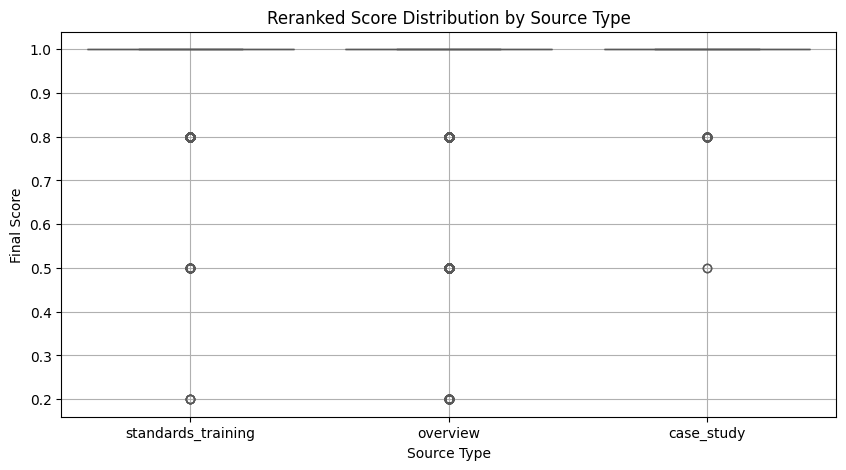

/tmp/ipython-input-33-2323161635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x="source_type", y="combined_score", palette="Set3")


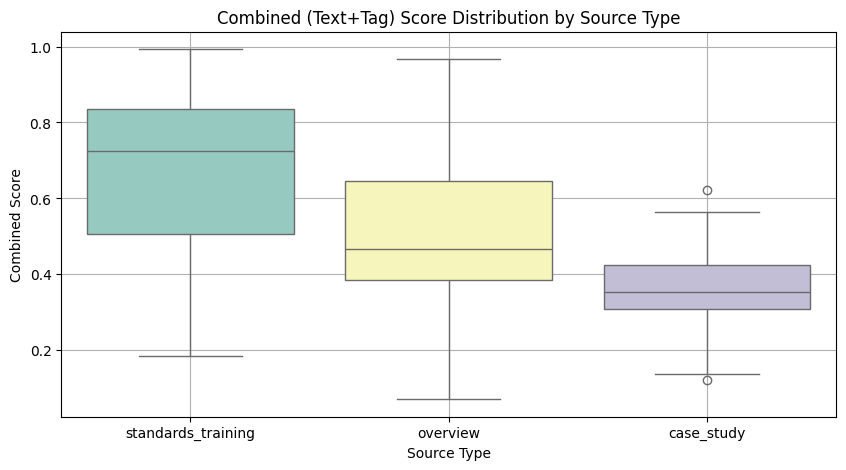

In [ ]:
# Boxplots

if 'analysis_df' not in globals():
    cols = list(final_results_df.columns)
    for i, item in enumerate(cols):
        if item in cols[:i]:
            count = cols[:i].count(item)
            cols[i] = f"{item}_{count}"
    analysis_df = final_results_df.copy()
    analysis_df.columns = cols
    analysis_df['performance_score'] = pd.to_numeric(analysis_df['performance_score'], errors='coerce')
    analysis_df['combined_score'] = pd.to_numeric(analysis_df['combined_score'], errors='coerce')

plt.figure(figsize=(10, 5))
sns.boxplot(data=analysis_df, x="source_type", y="performance_score", palette="Set2")
plt.title("Reranked Score Distribution by Source Type")
plt.ylabel("Final Score")
plt.xlabel("Source Type")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=analysis_df, x="source_type", y="combined_score", palette="Set3")
plt.title("Combined (Text+Tag) Score Distribution by Source Type")
plt.ylabel("Combined Score")
plt.xlabel("Source Type")
plt.grid(True)
plt.show()

In [ ]:
# Step 5.6: Coverage & Popularity

# Coverage
# Number of unique recommended pages
num_recommended_pages = final_results_df["target_url"].nunique()

# Total number of candidate pages in full dataset
total_available_pages = df_fe.shape[0]

# Coverage ratio
coverage_ratio = num_recommended_pages / total_available_pages
print(f"Coverage: {num_recommended_pages} / {total_available_pages} = {coverage_ratio:.2%}")

Coverage: 681 / 2089 = 32.60%


In [ ]:
# Step 5.7: Popularity Bias
if 'analysis_df' not in globals():
    cols = list(final_results_df.columns)
    for i, item in enumerate(cols):
        if item in cols[:i]:
            count = cols[:i].count(item)
            cols[i] = f"{item}_{count}"
    analysis_df = final_results_df.copy()
    analysis_df.columns = cols

# Get recommended target pages from df_fe
recommended_urls = analysis_df["target_url"].unique()
recommended_pages_df = df_fe[df_fe['URL'].isin(recommended_urls)]

# Compare mean popularity metrics
popularity_metrics = ["views_anon", "clicks_anon", "avg_time_on_page_anon"]

for col in popularity_metrics:
    df_fe[col] = pd.to_numeric(df_fe[col], errors='coerce')
    recommended_pages_df[col] = pd.to_numeric(recommended_pages_df[col], errors='coerce')

popularity_comparison = pd.DataFrame({
    "All Pages Mean": df_fe[popularity_metrics].mean().round(4),
    "Recommended Pages Mean": recommended_pages_df[popularity_metrics].mean().round(4)
})

# Display result
print("Popularity Bias Comparison")
popularity_comparison

Popularity Bias Comparison


/tmp/ipython-input-35-3418742230.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_pages_df[col] = pd.to_numeric(recommended_pages_df[col], errors='coerce')


,All Pages Mean,Recommended Pages Mean
views_anon,0.0031,0.0042
clicks_anon,0.0040,0.0053
avg_time_on_page_anon,0.0761,0.1131


## LLM-Assisted Manual Evaluation

In [ ]:
# Step 1: Sample 100 Source Pages with Specific Type Proportions

# Create index-to-URL lookup table from df_fe
index_to_url = df_fe.reset_index().set_index("index")["URL"].to_dict()

# Map source_index and target_index to actual URLs
final_full_results_df["source_url"] = final_full_results_df["source_index"].map(index_to_url)
final_full_results_df["target_url"] = final_full_results_df["target_index"].map(index_to_url)

# Set random seed for reproducibility
np.random.seed(42)

# Define sample size proportions
total_sample_size = 100
standards_n = 58     # ~58% standards_training
overview_n = 38      # ~38% overview
case_study_n = 4     # ~4% case_study

# Filter only the eligible page types from the full webpage dataset
eligible_df = df_fe[df_fe["page_type"].isin(["standards_training", "overview", "case_study"])]

# Sample source pages from each type independently
sample_standards = eligible_df[eligible_df["page_type"] == "standards_training"].sample(n=standards_n, replace=False)
sample_overview = eligible_df[eligible_df["page_type"] == "overview"].sample(n=overview_n, replace=False)
sample_case_study = eligible_df[eligible_df["page_type"] == "case_study"].sample(n=case_study_n, replace=False)

# Combine all sampled source pages into one dataframe
sample_sources_df = pd.concat([sample_standards, sample_overview, sample_case_study]).reset_index(drop=True)

# Extract source URLs to retrieve their recommendations later
sample_source_urls = sample_sources_df["URL"].tolist()

# Retrieve the corresponding top-k recommendations from the final model results
llm_eval_sample_df = final_full_results_df[final_full_results_df["source_url"].isin(sample_source_urls)].copy()

# Inspect the sample
llm_eval_sample_df.head()

,method,source_index,source_title,source_type,target_index,target_title,target_type,score,combined_score,structural_boost,performance_score,text_weight,tag_weight,source_url,target_url
115,Final,23,SA 8000 Social Accountability Awareness On-demand,standards_training,355,Fundamentals of Net Zero On-Demand Training Co...,standards_training,0.9785,0.784830,1.0,1.0,0.4,0.6,https://www.bsigroup.com/en-GB/training-course...,https://www.bsigroup.com/en-GB/training-course...
116,Final,23,SA 8000 Social Accountability Awareness On-demand,standards_training,395,Climate Change and Management Systems On-deman...,standards_training,0.9767,0.767176,1.0,1.0,0.4,0.6,https://www.bsigroup.com/en-GB/training-course...,https://www.bsigroup.com/en-GB/training-course...
117,Final,23,SA 8000 Social Accountability Awareness On-demand,standards_training,297,Introduction to Sustainability Reporting On-de...,standards_training,0.9750,0.749836,1.0,1.0,0.4,0.6,https://www.bsigroup.com/en-GB/training-course...,https://www.bsigroup.com/en-GB/training-course...
118,Final,23,SA 8000 Social Accountability Awareness On-demand,standards_training,29,ISO 20121:2024 Event Sustainability Management...,standards_training,0.9749,0.748556,1.0,1.0,0.4,0.6,https://www.bsigroup.com/en-GB/training-course...,https://www.bsigroup.com/en-GB/training-course...
119,Final,23,SA 8000 Social Accountability Awareness On-demand,standards_training,252,ISO 20121 Event Sustainability Management - Un...,standards_training,0.9704,0.703524,1.0,1.0,0.4,0.6,https://www.bsigroup.com/en-GB/training-course...,https://www.bsigroup.com/en-GB/training-course...


In [ ]:
# Step 2: Merge source and target info into llm_eval_sample_df

# Define which columns to extract from df_fe
def extract_columns(df):
    return df[[
        "URL", "title", "description", "page_type",
        "industries-tag", "themes-tag", "search-tag",
        "views_anon", "clicks_anon", "avg_time_on_page_anon"
    ]].copy()

# Extract relevant columns for merging
df_info = extract_columns(df_fe)

# Rename for source fields
source_info = df_info.add_prefix("source_")
source_info = source_info.rename(columns={"source_URL": "source_url"})

# Rename for target fields
target_info = df_info.add_prefix("target_")
target_info = target_info.rename(columns={"target_URL": "target_url"})

# Merge source information into evaluation sample
llm_eval_sample_df = llm_eval_sample_df.merge(source_info, on="source_url", how="left", suffixes=("", "_source_extra"))

# Merge target information into evaluation sample
llm_eval_sample_df = llm_eval_sample_df.merge(target_info, on="target_url", how="left", suffixes=("", "_target_extra"))

# Check merged data
llm_eval_sample_df[[
    "source_title", "source_page_type", "target_title", "target_page_type",
    "source_industries-tag", "target_themes-tag", "source_avg_time_on_page_anon", "target_avg_time_on_page_anon"
]].head()

,source_title,source_page_type,target_title,target_page_type,source_industries-tag,target_themes-tag,source_avg_time_on_page_anon,target_avg_time_on_page_anon
0,SA 8000 Social Accountability Awareness On-demand,standards_training,Fundamentals of Net Zero On-Demand Training Co...,standards_training,Other,Sustainability,0.0629,0.1011
1,SA 8000 Social Accountability Awareness On-demand,standards_training,Climate Change and Management Systems On-deman...,standards_training,Other,Sustainability,0.0629,0.1145
2,SA 8000 Social Accountability Awareness On-demand,standards_training,Introduction to Sustainability Reporting On-de...,standards_training,Other,Sustainability,0.0629,0.1085
3,SA 8000 Social Accountability Awareness On-demand,standards_training,ISO 20121:2024 Event Sustainability Management...,standards_training,Other,Sustainability,0.0629,0.1063
4,SA 8000 Social Accountability Awareness On-demand,standards_training,ISO 20121 Event Sustainability Management - Un...,standards_training,Other,Sustainability,0.0629,0.1132


In [ ]:
# Step 3: Construct LLM Prompts and Perform Multi-Dimensional Evaluation

# Load Gemini 1.5 flash model
model = genai.GenerativeModel("gemini-1.5-flash")

# Step 3.1: Format LLM prompt for multi-criteria evaluation
def format_combined_prompt(row):
    prompt = f"""
You are evaluating a content recommendation.

Below is a source page and its recommended page. First, score the recommendation across **five quality dimensions**. Then, decide whether the recommendation is **relevant** overall, and explain your reasoning.

== Source Page ==
Title: {row['source_title']}
Type: {row['source_page_type']}
Tags: {row['source_industries-tag']}
Average Time on Page: {row['source_avg_time_on_page_anon']} sec

== Recommended Page ==
Title: {row['target_title']}
Type: {row['target_page_type']}
Tags: {row['target_themes-tag']}
Average Time on Page: {row['target_avg_time_on_page_anon']} sec

== Task ==

Step 1: Rate the recommendation (scale: 1 to 5)
- Relevance – How well does the recommendation align with the source topic and user intent?
- Diversity – Does it bring a different angle or sub-topic?
- Novelty – Is the content fresh and non-redundant?
- Coverage – Does it help broaden the content scope?
- Popularity Bias – Is it not just suggesting very popular items?

Step 2: Is this recommendation overall relevant?
Step 3: Give a short justification.

Respond strictly in this format:
Relevance: <1–5>
Diversity: <1–5>
Novelty: <1–5>
Coverage: <1–5>
Popularity Bias: <1–5>
Relevant: <Yes/No>
Justification: <1–2 sentence explanation>
""".strip()
    return prompt

In [ ]:
llm_eval_sample_df = llm_eval_sample_df.dropna(subset=["source_title", "target_title", "source_industries-tag", "target_themes-tag"])

llm_eval_sample_df["llm_prompt"] = llm_eval_sample_df.apply(format_combined_prompt, axis=1)

/tmp/ipython-input-39-807752241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llm_eval_sample_df["llm_prompt"] = llm_eval_sample_df.apply(format_combined_prompt, axis=1)


In [ ]:
# Step 3.2: Submit prompt to LLM and parse result
def parse_combined_llm_response(text):
    scores = {
        "Relevance": None,
        "Diversity": None,
        "Novelty": None,
        "Coverage": None,
        "Popularity Bias": None,
        "Relevant": None,
        "Justification": None,
        "Raw_Response": text
    }

    # Extract numeric scores
    for dim in ["Relevance", "Diversity", "Novelty", "Coverage", "Popularity Bias"]:
        match = re.search(rf"{dim}[:：]?\s*(\d(?:\.\d)?)", text, re.IGNORECASE)
        if match:
            scores[dim] = float(match.group(1))

    # Extract Relevant: Yes/No
    match_rel = re.search(r"Relevant[:：]?\s*(Yes|No)", text, re.IGNORECASE)
    if match_rel:
        scores["Relevant"] = match_rel.group(1).strip().lower() == "yes"

    # Extract Justification
    match_just = re.search(r"Justification[:：]?\s*(.+)", text, re.IGNORECASE | re.DOTALL)
    if match_just:
        scores["Justification"] = match_just.group(1).strip()

    return pd.Series(scores)


In [ ]:
# Step 3.3: Call Gemini and parse result
def evaluate_prompt_with_gemini(prompt):
    try:
        # print(f"DEBUG: Sending prompt (first 100 chars): {prompt[:100]}...") # for debugging
        response = model.generate_content(prompt)
        text = response.text.strip()
        # print(f"DEBUG: Raw response text: {text}") # for debugging

        if text == "" or text is None:
            # print("DEBUG: Gemini returned empty text.") # for debugging
            # Return an explicit empty response instead of causing parsing to fail
            return pd.Series({
                "Relevance": None, "Diversity": None, "Novelty": None,
                "Coverage": None, "Popularity Bias": None,
                "Relevant": None, "Justification": "Empty LLM response",
                "Raw_Response": "Empty LLM response"
            })

        parsed_result = parse_combined_llm_response(text)
        # print(f"DEBUG: Parsed result: {parsed_result}") # for debugging
        return parsed_result

    except Exception as e:
        # print(f"DEBUG: Error during Gemini call or parsing: {e}") # for debugging
        return pd.Series({
            "Relevance": None, "Diversity": None, "Novelty": None,
            "Coverage": None, "Popularity Bias": None,
            "Relevant": None, "Justification": f"Error: {str(e)}",
            "Raw_Response": f"Error: {str(e)}"
        })


In [ ]:
# Step 3.4: Batched Execution with Interval Strategy
def batch_evaluate_prompts(df, prompt_col, batch_size=5, sleep_time=20):
    results = []
    total = len(df)

    for i in tqdm(range(0, total, batch_size), desc="Batch scoring with LLM..."):
        batch_prompts = df[prompt_col].iloc[i:i+batch_size]
        for prompt in batch_prompts:
            retry = 0
            success = False
            while not success and retry < 3:
                try:
                    row_result = evaluate_prompt_with_gemini(prompt)
                    success = True
                except Exception as e:
                    retry += 1
                    time.sleep(10)
                    if retry >= 3:
                        row_result = pd.Series({
                            "Relevance": None,
                            "Diversity": None,
                            "Novelty": None,
                            "Coverage": None,
                            "Popularity Bias": None,
                            "Relevant": None,
                            "Justification": f"[Error] {str(e)}",
                            "Raw_Response": ""
                        })
                results.append(row_result)
        time.sleep(sleep_time)

    return pd.DataFrame(results)

In [ ]:
llm_scores_raw = batch_evaluate_prompts(llm_eval_sample_df, "llm_prompt", batch_size=5, sleep_time=1)

Batch scoring with LLM...: 100%|██████████| 96/96 [18:48<00:00, 11.75s/it]


In [ ]:
llm_scores_df = llm_scores_raw["Raw_Response"].apply(parse_combined_llm_response)
llm_scores_df.head()

,Relevance,Diversity,Novelty,Coverage,Popularity Bias,Relevant,Justification,Raw_Response
0,2.0,4.0,4.0,3.0,5.0,False,While both pages deal with on-demand training ...,Relevance: 2\nDiversity: 4\nNovelty: 4\nCovera...
1,2.0,3.0,4.0,2.0,5.0,False,While both pages concern standards-based train...,Relevance: 2\nDiversity: 3\nNovelty: 4\nCovera...
2,3.0,4.0,4.0,3.0,5.0,True,Both pages concern on-demand standards trainin...,Relevance: 3\nDiversity: 4\nNovelty: 4\nCovera...
3,2.0,3.0,4.0,3.0,5.0,False,While both pages concern standards and trainin...,Relevance: 2\nDiversity: 3\nNovelty: 4\nCovera...
4,3.0,4.0,4.0,3.0,5.0,True,"Both pages concern standards and training, wh...",Relevance: 3\nDiversity: 4\nNovelty: 4\nCovera...


In [ ]:
llm_scores_df.to_csv("llm_scores_df_partial.csv", index=False)

In [ ]:
llm_scores_df["Relevant"].value_counts()

,count
Relevant,
False,261
True,197


In [ ]:
# Step 4: Aggregate LLM Evaluation Results

# Step 4.1: Combine source metadata + LLM scores
llm_eval_scored_df = pd.concat(
    [llm_eval_sample_df.reset_index(drop=True), llm_scores_df.reset_index(drop=True)],
    axis=1
)


# Step 4.2: Compute mean scores by each metric
score_cols = ["Relevance", "Diversity", "Novelty", "Coverage", "Popularity Bias"]

overall_score_means = llm_eval_scored_df[score_cols].mean().round(2)

# Convert Series to 1-row DataFrame for prettier display
overall_score_means_df = pd.DataFrame(overall_score_means).T
overall_score_means_df.index = ["Average Across All"]


print("Average Scores Across All Recommendations:")
display(overall_score_means_df)


# Step 4.3: Breakdown by source page type
target_type_means = (
    llm_eval_scored_df
    .groupby("target_page_type")[score_cols]
    .mean()
    .round(2)
)

print("Average Scores by Target Page Type:")
display(target_type_means)

Average Scores Across All Recommendations:


,Relevance,Diversity,Novelty,Coverage,Popularity Bias
Average Across All,2.43,2.82,2.93,2.32,4.31


Average Scores by Target Page Type:


,Relevance,Diversity,Novelty,Coverage,Popularity Bias
target_page_type,,,,,
case_study,2.36,3.76,3.20,2.56,4.44
overview,2.59,3.06,3.14,2.49,4.14
standards_training,2.40,2.70,2.86,2.27,4.34


In [ ]:
# Step 5: LLM-Based Justification Rule Induction

# Use more reliable model for final judgment
model = genai.GenerativeModel("gemini-1.5-pro")

# Step 5.1: Prepare prompt and sample relevant responses

# 1. Filter valid relevant entries with non-empty raw response
valid_relevant = (
    llm_eval_scored_df
    .query("Relevant == True")
    .dropna(subset=["Raw_Response"])
)

# 2. Sample up to 50 examples (if fewer, take all)
sample_relevant_raws = valid_relevant.sample(
    n=min(50, len(valid_relevant)),
    random_state=42
)["Raw_Response"].tolist()

# 3. Build the instruction prompt
induction_prompt = (
    "You are a recommendation evaluation expert.\n\n"
    "Below are examples of LLM-evaluated content recommendations that were judged to be **relevant** (i.e., effective).\n"
    "Each sample includes numeric scores and a justification.\n\n"
    "Your task is to analyze these samples and **induce a decision rule** that can be used to automatically determine whether a recommendation is effective.\n"
    "Your rule should include:\n"
    "- Must provide a specific value thresholds for each metric (Relevance, Diversity, Novelty, Coverage, Popularity Bias)\n"
    "- Optional composite rules (e.g., (Diversity + Novelty)/2 ≥ 2.5)\n"
    "- A short explanation of why these thresholds make sense\n\n"
    "Here are the examples:\n"
)

# 4. Append each raw response to the prompt
for i, text in enumerate(sample_relevant_raws):
    induction_prompt += f"\n--- Sample {i+1} ---\n{text.strip()}\n"

In [ ]:
# Step 5.2: Ask LLM to generate the effectiveness rule
response = model.generate_content(induction_prompt)

# Print the result
print("LLM-Inferred Rule for Effective Recommendations:\n")
print(response.text.strip())

LLM-Inferred Rule for Effective Recommendations:

Decision Rule for Effective Content Recommendations:

A recommendation is deemed **effective (relevant)** if it meets the following criteria:

* **Relevance:** ≥ 3
* **Diversity:**  ≥ 2  (While higher diversity is generally preferable, the examples show relevance even at lower diversity scores if the thematic connection is strong.)
* **Novelty:** Not a primary factor for determining relevance.
* **Coverage:** Not a primary factor for determining relevance.
* **Popularity Bias:** Not a primary factor for determining relevance.

**Explanation:**

* **Relevance Threshold (≥ 3):**  A score of 3 or higher indicates a sufficient thematic connection between the source and recommended content. The justifications consistently highlight the presence of shared themes, related concepts, or complementary information even when the topics are not identical.  A score below 3 suggests a weak connection, making the recommendation less likely to be useful

In [ ]:
# Step 5.3: Apply LLM-Inferred Rule to Determine Effectiveness (Updated with secondary checks)

def apply_llm_rule(row):
    rel = row.get("Relevance", 0)
    div = row.get("Diversity", 0)
    nov = row.get("Novelty", 0)
    cov = row.get("Coverage", 0)

    try:
        # Primary requirement: Relevance ≥ 3
        if rel >= 2.0:
            # Secondary requirement: Diversity ≥ 2
            if div >= 2:
                return True
            else:
                # Even if relevance is strong, diversity must meet minimum threshold
                return False
        else:
            return False
    except Exception as e:
        # Record error for debugging
        print(f"Error processing row: {e}")
        return None


# Apply the rule to all rows
llm_eval_scored_df["Effective_ByRule"] = llm_eval_scored_df.apply(apply_llm_rule, axis=1)

# Calculate and print the overall effectiveness rate
overall_byrule = llm_eval_scored_df["Effective_ByRule"].mean() * 100
print(f"Overall Effective Rate by LLM Rule: {overall_byrule:.2f}%")

# Breakdown by source type
breakdown_by_type = (
    llm_eval_scored_df
    .groupby("source_type")["Effective_ByRule"]
    .mean()
    .mul(100)
    .round(2)
    .reset_index()
    .rename(columns={"Effective_ByRule": "Effective Rate (%)"})
)

# Display result
import IPython.display as display
display.display(breakdown_by_type)


Overall Effective Rate by LLM Rule: 60.46%


,source_type,Effective Rate (%)
0,case_study,90.00
1,overview,65.90
2,standards_training,55.09
